## -NLP를 활용한 추천 시스템 구현
### 신규 고객의 경우, 협업 필터링 적용이 어려운 콜드스타트 문제가 있다. 그래서 이를 개선하고자, 고객의 검색어나 텍스트 로그 데이터를 바탕으로, 카테고리를 예측한 후, 해당 카테고리에서 평점 + 가중치(구매 누적 수량)이 높은 상위 5개 제품을 추천해주는 방식을 구현하는 것이 목적이다.
### 그래서, 현재 이 파일에서는 NLP를 통해 카테고리 예측 분류 모델을 구현해볼 것이다.
#### 참고사항 : Recommendation_line.ipynb의 두번째 모델이 카테고리 분류된 이후, 추천되는 라인을 구현하였음.(현재 이 파일에는 NLP 카테고리 예측 모델만 구현되어 있음)

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 40 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (6,941 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 160837 files and d

In [ ]:
pip install beautifulsoup4

In [ ]:
pip install transformers

     |████████████████████████████████| 2.6 MB 5.0 MB/s 
     |████████████████████████████████| 3.3 MB 31.4 MB/s 
     |████████████████████████████████| 636 kB 41.5 MB/s 
     |████████████████████████████████| 895 kB 78.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import os

import spacy
import re
import scipy.stats as stats
import warnings
warnings.filterwarnings(action = 'ignore')
nlp = spacy.load('en_core_web_sm')

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, KFold, cross_val_score
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score, roc_curve, mean_squared_error
from xgboost import XGBClassifier
from sklearn.metrics.pairwise import cosine_similarity
import random

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from urllib import request
request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Unzipp

True

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Data/project_data/train_40k.csv')
test = pd.read_csv('/content/drive/MyDrive/Data/project_data/val_10k.csv')

In [ ]:
## 데이터의 문장 길이 시긱화
def length_text(data, title):
    print('길이의 최댓값:{}'.format(np.max(data)))
    print('길이의 최솟값:{}'.format(np.min(data)))
    print('길이의 평균값:{}'.format(np.mean(data)))
    print('길이의 표준편차:{}'.format(np.std(data)))
    print('길이의 중간값:{}'.format(np.median(data)))

    plt.figure(figsize = (20, 10))
    plt.hist(data, bins = 200, alpha = 0.5, color = 'r', label = 'word')
    plt.yscale('log', nonposy = 'clip')
    plt.title(title, fontsize = 30)
    plt.xlabel('Length of Review', fontsize = 20)
    plt.ylabel('Number of Review', fontsize = 20)
    
    return plt.show()

## 데이터의 사분위 값 시각화
def length_text2(data, title):
    print('길이의 최댓값:{}'.format(np.max(data)))
    print('길이의 최솟값:{}'.format(np.min(data)))
    print('길이의 평균값:{}'.format(np.mean(data)))
    print('길이의 표준편차:{}'.format(np.std(data)))
    print('길이의 중간값:{}'.format(np.median(data)))

    plt.figure(figsize = (20, 10))
    plt.boxplot(data, labels = ['counts'], showmeans = True)
    plt.title(title, fontsize = 30)

    return plt.show()

## 단어 빈도 수 시각화
def text_size(data):
    data_review = [review for review in data if type(review) is str]
    wordcloud = WordCloud('NanumGothic.ttf').generate(' '.join(data_review))
    plt.figure(figsize = (20, 10))
    plt.title('Word frequency', fontsize = 30)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    
    return plt.show()

In [ ]:
length = train['Text'].astype('str').apply(len)
train_word_counts = train['Text'].astype(str).apply(lambda x : len(x.split(' ')))

길이의 최댓값:6589
길이의 최솟값:1
길이의 평균값:435.201875
길이의 표준편차:389.34721152396565
길이의 중간값:323.0


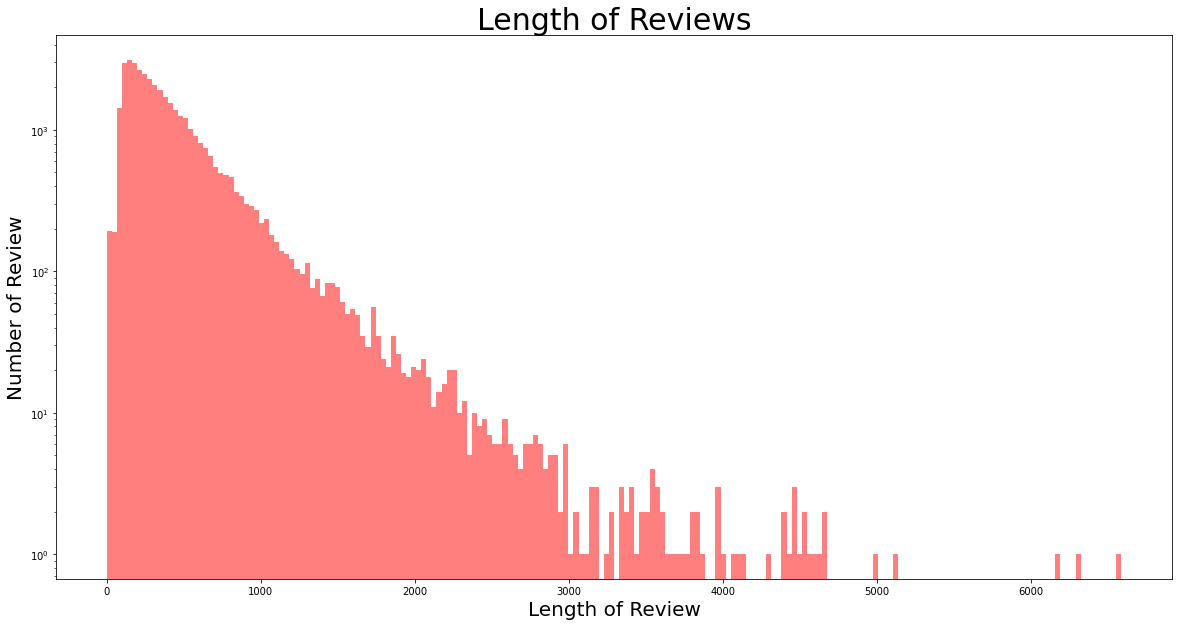

길이의 최댓값:6589
길이의 최솟값:1
길이의 평균값:435.201875
길이의 표준편차:389.34721152396565
길이의 중간값:323.0


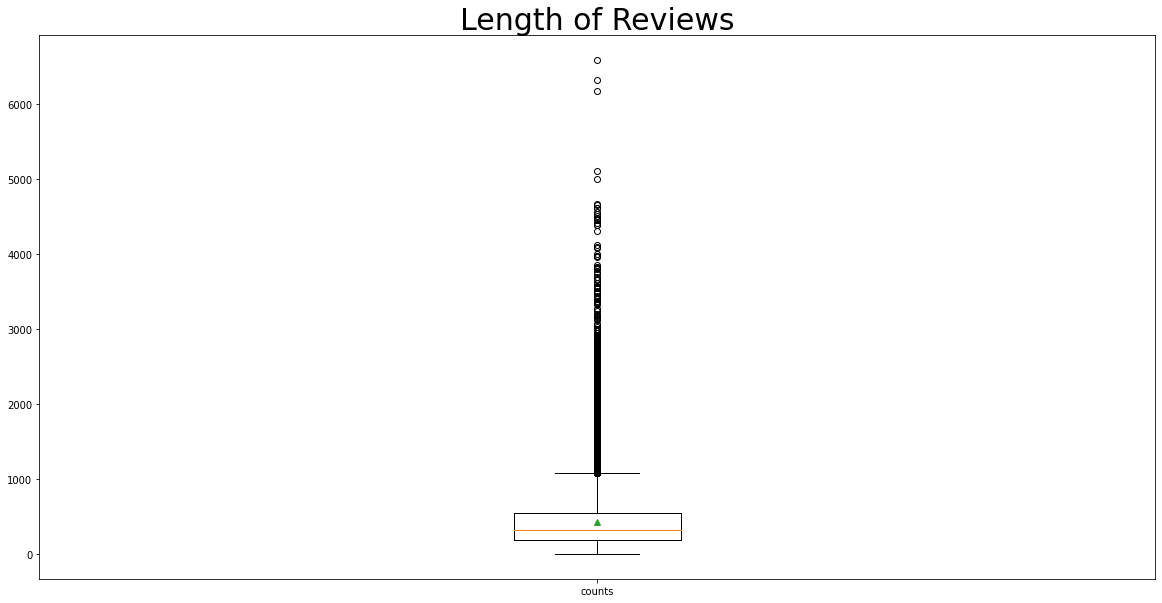

(None, None)

In [ ]:
length_text(length, 'Length of Reviews'), length_text2(length, 'Length of Reviews')

길이의 최댓값:1149
길이의 최솟값:1
길이의 평균값:82.361075
길이의 표준편차:72.7022540905318
길이의 중간값:62.0


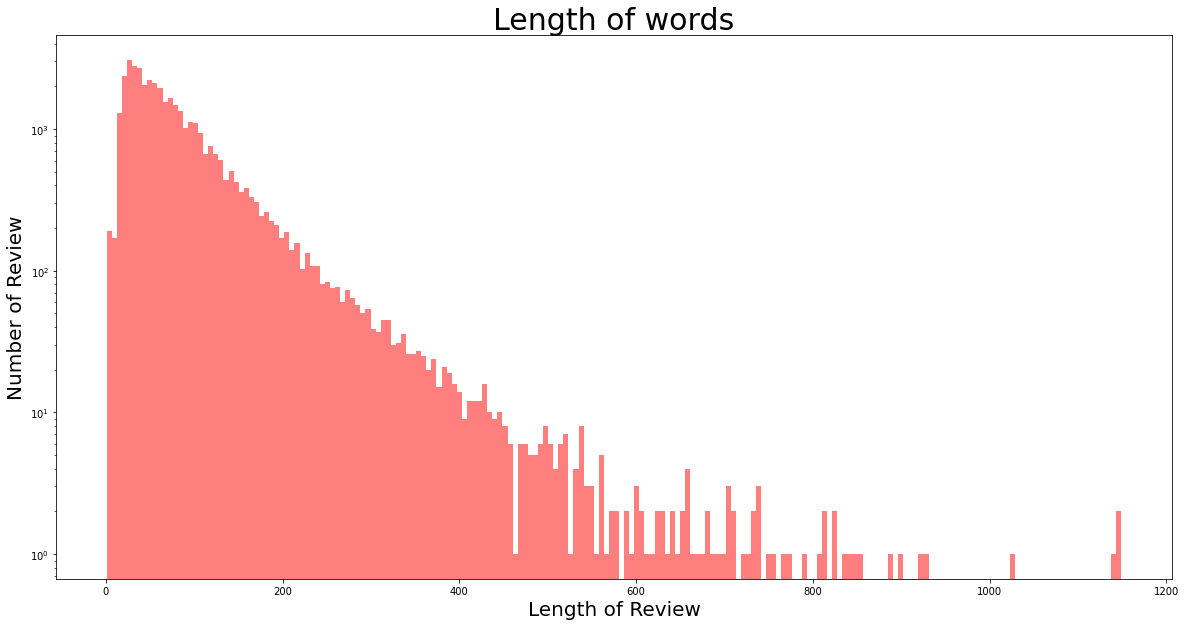

길이의 최댓값:1149
길이의 최솟값:1
길이의 평균값:82.361075
길이의 표준편차:72.7022540905318
길이의 중간값:62.0


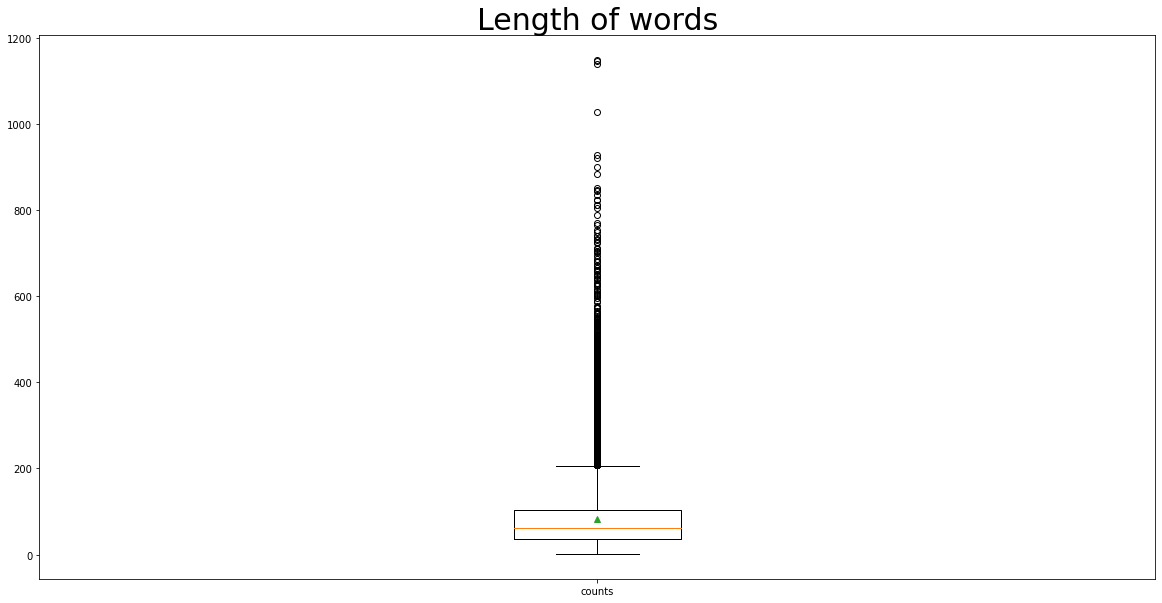

In [ ]:
length_text(train_word_counts, 'Length of words'), 
length_text2(train_word_counts, 'Length of words')

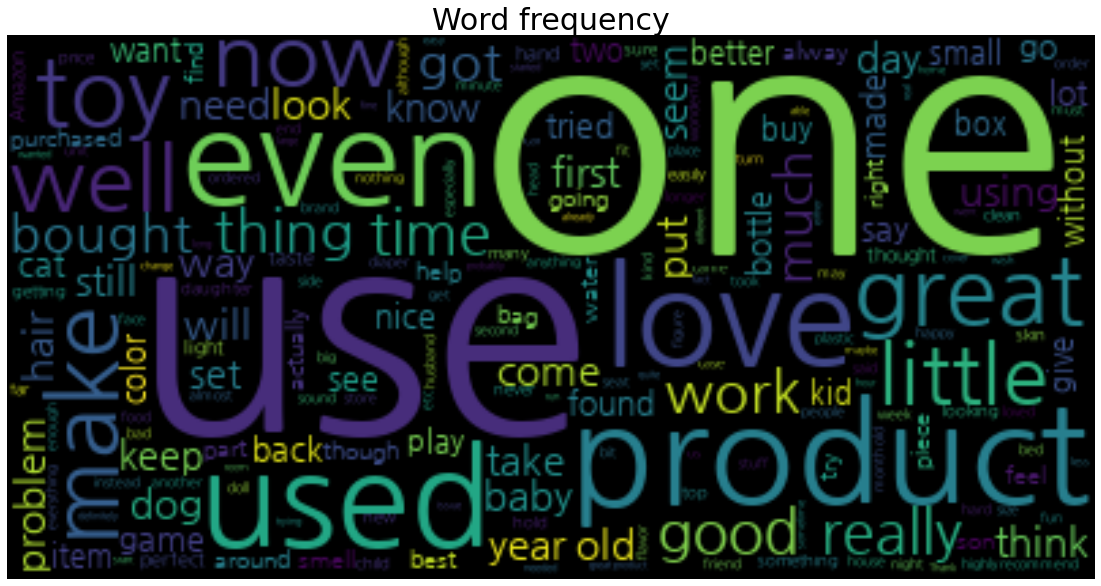

In [ ]:
text_size(train['Text'])

In [ ]:
feature = ['Text']
target2 = ['Cat2']
target1 = ['Cat1']

In [ ]:
X_train = train[feature]
y_train1 = train[target1]
y_train2 = train[target2]

X_test = test[feature]
y_test1 = test[target1]
y_test2 = test[target2]

Cat1의 클래스 수: 6
----------------------------
Cat2의 클래스 수: 64


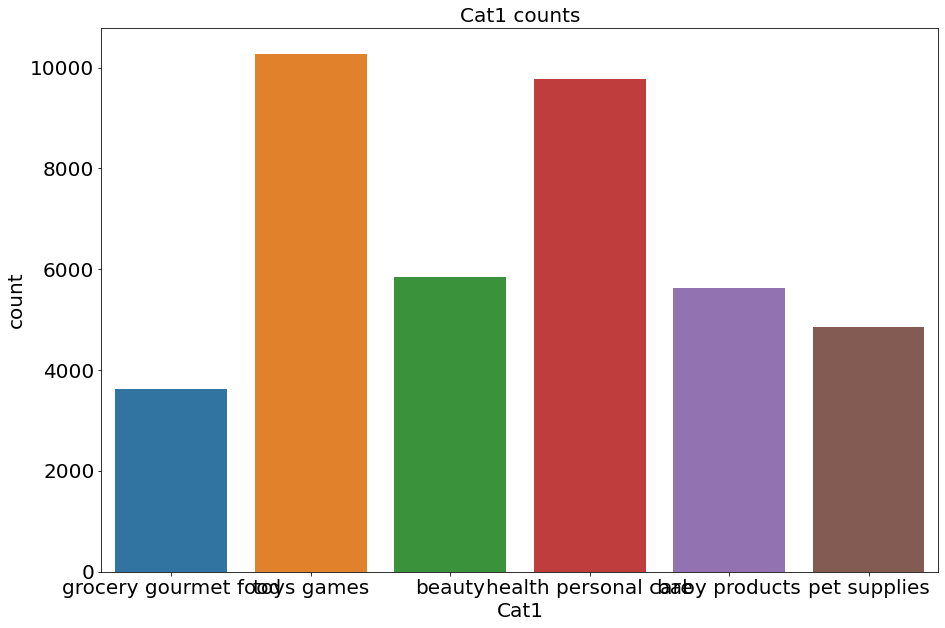

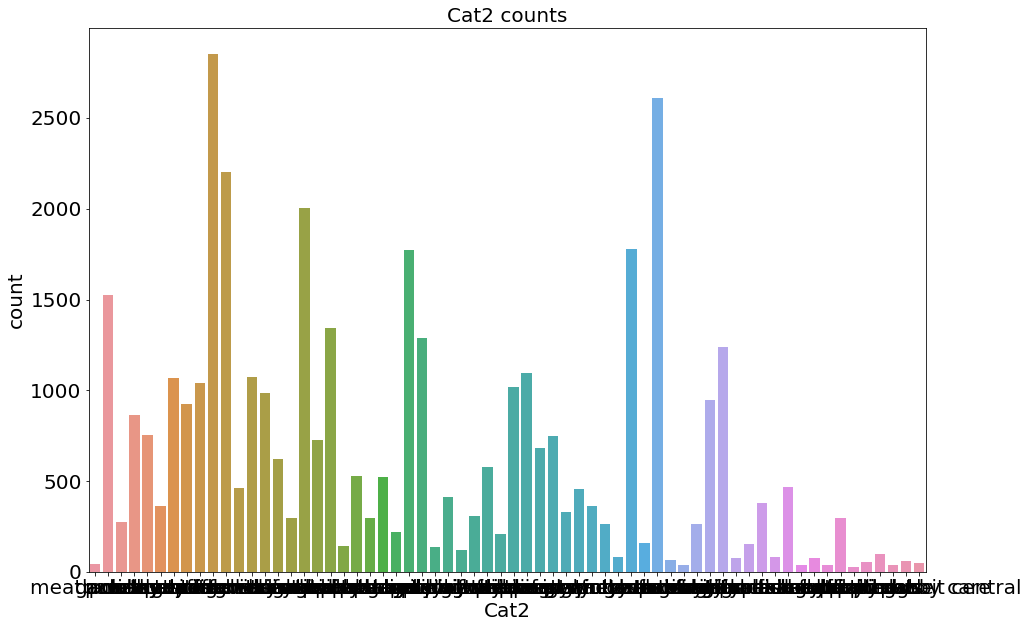

In [ ]:
print('Cat1의 클래스 수:', len(y_train1.value_counts()))
plt.figure(figsize = (15, 10))
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel('', fontsize = 20)
plt.ylabel('', fontsize = 20)
plt.title('Cat1 counts', fontsize = 20)
sns.countplot(y_train1['Cat1'])
print('----------------------------')
print('Cat2의 클래스 수:', len(y_train2.value_counts()))
plt.figure(figsize = (15, 10))
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel('', fontsize = 20)
plt.ylabel('', fontsize = 20)
plt.title('Cat2 counts', fontsize = 20)
sns.countplot(y_train2['Cat2'])

우선적으로, version1에서 Cat2를 예측하는 것의 경우, Cat1보다 많은 다중 클래스이기 때문에 성능이 안좋은 것을 확인하였다.
그래서 이번에는 우선적으로, Cat1로 성능이 가장 좋은 모델로 Cat2를 예측하도록 진행하겠다.

In [ ]:
stop_words = set(stopwords.words('english'))
print('불용어 개수 :', len(stop_words))
print(stop_words)

불용어 개수 : 179
{"should've", 'why', 'now', 'don', "it's", 'while', 'mightn', 'needn', 'down', 'aren', 'himself', 'have', 'shouldn', 'haven', 'below', 'again', 'there', 'my', "she's", 'or', "isn't", 'too', 'ours', 'over', 're', 'each', 'where', 'he', "hasn't", 'does', 'them', 'then', 'more', "weren't", 'which', 'until', 'through', "shan't", 'some', 't', "don't", 'll', 'won', 'has', 'their', 'yours', 'from', 'do', "you'd", "you've", 'at', 'its', 'but', "didn't", 'on', 'before', "haven't", "hadn't", 'into', "couldn't", 'weren', "needn't", 'up', 'with', 'were', 'for', 'few', 'herself', 'i', "you're", 'him', 'and', 'having', 've', 'your', "you'll", 'here', 'the', 'any', 'both', "aren't", 'very', 'if', "won't", 'she', 's', 'an', 'all', 'yourselves', 'themselves', 'we', 'so', 'o', 'how', 'been', 'me', 'being', 'about', 'between', 'our', 'theirs', 'isn', 'it', 'these', 'd', 'after', 'whom', 'to', 'itself', 'be', 'against', 'of', "that'll", 'this', "mightn't", 'are', 'ourselves', 'didn', 'who', '

In [ ]:
def clean_text(sentence, remove_stopwords = True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열  제거 Ex) my husband (and myself) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
#     sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah

    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stop_words if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [ ]:
X_train['Text'] = X_train['Text'].apply(clean_text)
X_test['Text'] = X_test['Text'].apply(clean_text)

In [ ]:
length_eda = X_train['Text'].astype('str').apply(len)
train_word_counts_eda = X_train['Text'].astype(str).apply(lambda x : len(x.split(' ')))

In [ ]:
X_train['length'] = X_train['Text'].apply(lambda x : len(x)) ## 최솟값이 0으로 나오기 때문에 0인값을 추출해본다.

In [ ]:
X_train['word_len'] = X_train['Text'].apply(lambda x : x.split()).apply(lambda x : len(x))

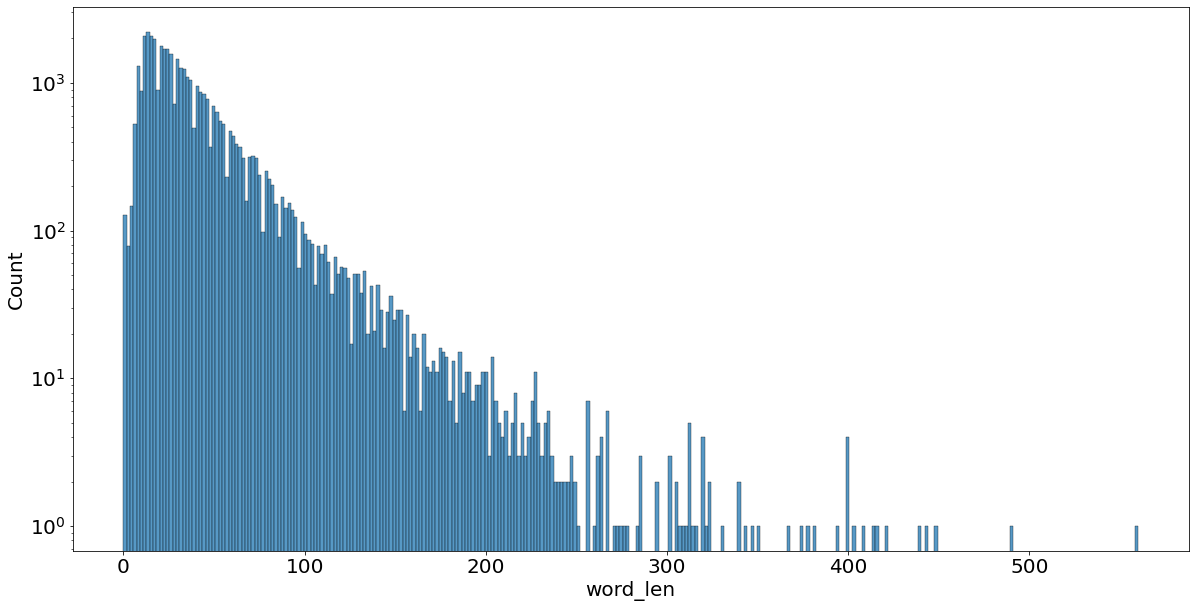

In [ ]:
plt.figure(figsize = (20, 10))
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.yscale('log')
plt.xlabel('', fontsize = 20)
plt.ylabel('', fontsize = 20)
sns.histplot(X_train['word_len'])

In [ ]:
X_train['length'].describe()

count    40000.000000
mean       250.908525
std        222.558874
min          0.000000
25%        111.000000
50%        187.000000
75%        314.000000
max       4098.000000
Name: length, dtype: float64

In [ ]:
X_train = X_train[X_train['word_len'] > 10]
X_train

,Text,length,word_len
0,description photo product needs changed indica...,84,11
1,great book well thought easily imagine events ...,167,25
2,first year teacher teaching th grade special r...,320,49
3,got book bookfair school looking something sum...,299,42
4,hi martine redman created puzzle briarpatch us...,460,63
...,...,...,...
39995,even convenient find really small store tiny a...,94,14
39996,wore next day eating chinese take ankles went ...,87,15
39997,ok product really stay fog free long useful co...,61,11
39998,glitter body lotion offers tremendous sparkle ...,299,42


In [ ]:
token = Tokenizer()
token.fit_on_texts(X_train['Text'])

In [ ]:
threshold = 8
total_cnt = len(token.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in token.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 44545
등장 빈도가 7번 이하인 희귀 단어의 수: 33602
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10943
단어 집합에서 희귀 단어의 비율: 75.43383095745875
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.411862024421815


7회 이하로 나온 희귀단어를 제외하면 대략 11,000개가 된다. 10,000개의 빈도수가 높은 단어를 추출하여 진행하였다.

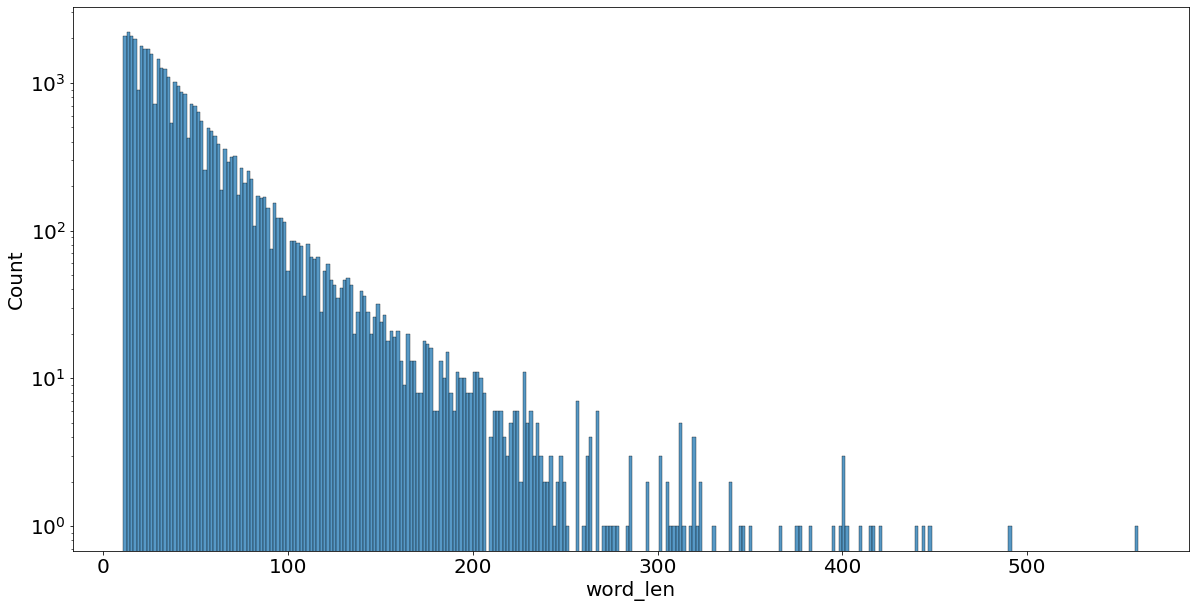

In [ ]:
plt.figure(figsize = (20, 10))
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.yscale('log')
plt.xlabel('', fontsize = 20)
plt.ylabel('', fontsize = 20)
sns.histplot(X_train['word_len'])

In [ ]:
X_train['word_len'].mean()

40.90266349068861

In [ ]:
X_train1 = pd.merge(X_train.reset_index(), train[['Cat1', 'Cat2']].reset_index(), how = 'inner', on = 'index')

In [ ]:
X_train1

,index,Text,length,word_len,Cat1,Cat2
0,0,description photo product needs changed indica...,84,11,grocery gourmet food,meat poultry
1,1,great book well thought easily imagine events ...,167,25,toys games,games
2,2,first year teacher teaching th grade special r...,320,49,toys games,games
3,3,got book bookfair school looking something sum...,299,42,toys games,games
4,4,hi martine redman created puzzle briarpatch us...,460,63,toys games,puzzles
...,...,...,...,...,...,...
36939,39995,even convenient find really small store tiny a...,94,14,beauty,makeup
36940,39996,wore next day eating chinese take ankles went ...,87,15,health personal care,medical supplies equipment
36941,39997,ok product really stay fog free long useful co...,61,11,beauty,tools accessories
36942,39998,glitter body lotion offers tremendous sparkle ...,299,42,beauty,skin care


In [ ]:
token = Tokenizer(num_words=10000) ## 빈도수가 높은 10,000개의 단어
token.fit_on_texts(X_train1['Text'])
sequences = token.texts_to_sequences(X_train1['Text'])
sequences = pad_sequences(sequences, maxlen= 100, padding = 'post')
word_index = token.word_index

sequences_test = token.texts_to_sequences(X_test['Text'])
sequences_test = pad_sequences(sequences_test, maxlen= 100, padding = 'post')

In [ ]:
y_train1 = X_train1[['Cat1']]
y_train2 = X_train1[['Cat2']]

In [ ]:
sequences.shape, y_train1.shape

((36944, 100), (36944, 1))

In [ ]:
# 문자열 데이터를 인코딩 형태로 변환해줌.
from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder()
encoder = OrdinalEncoder()

In [ ]:
y_train_enc1 = enc.fit_transform(y_train1)
y_train_enc2 = encoder.fit_transform(y_train2)
y_test_enc1 = enc.transform(y_test1)
y_test_enc2 = encoder.transform(y_test2)

### LSTM 다중 클래스 모델

In [ ]:
## 하이퍼 파라미터 세팅
batch_size = 256
num_epochs = 30
vocab_size = len(word_index)+1
emb_size = 128
hidden_dimension = 256
output_dimension = 6
tf.random.set_seed(411)
np.random.seed(411)

In [ ]:
vocab_size

44546

In [ ]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])

tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

strategy = tf.distribute.TPUStrategy(resolver)

with strategy.scope():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(10000, emb_size))
    model.add(tf.keras.layers.Dense(256, activation = 'relu'))
    model.add(tf.keras.layers.Dropout(0.7))
    model.add(tf.keras.layers.LSTM(512, return_sequences=True))
    model.add(tf.keras.layers.LSTM(512))
    model.add(tf.keras.layers.Dropout(0.6))
    model.add(tf.keras.layers.Dense(hidden_dimension, activation = 'relu'))
    model.add(tf.keras.layers.Dropout(0.6))
    model.add(tf.keras.layers.Dense(output_dimension, activation = 'softmax'))

    model_name = "lstm_classifier"

    # overfitting을 막기 위한 ealrystop 추가
    earlystop_callback = EarlyStopping(monitor='val_loss', min_delta=0.0001,patience=10, restore_best_weights=True)
    # min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
    # patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)\

    checkpoint_path = os.path.join(model_name, 'weights.h5')
    checkpoint_dir = os.path.dirname(checkpoint_path)

    # Create path if exists
    if os.path.exists(checkpoint_dir):
        print("{} -- Folder already exists \n".format(checkpoint_dir))
    else:
        os.makedirs(checkpoint_dir, exist_ok=True)
        print("{} -- Folder create complete \n".format(checkpoint_dir))
        
    cp_callback = ModelCheckpoint(
        checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 15)

    model.compile(optimizer = tf.keras.optimizers.RMSprop(1e-4),
                loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics = [tf.keras.metrics.SparseCategoricalAccuracy(name = 'accuracy')])

history = model.fit(sequences, y_train_enc1, epochs=50, batch_size=64, callbacks=[es, cp_callback], validation_split = 0.2)

INFO:tensorflow:Initializing the TPU system: grpc://10.48.105.170:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.48.105.170:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


lstm_classifier -- Folder already exists 

Epoch 1/50


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 100) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 1) dtype=float32>]
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 100) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 1) dtype=float32>]


462/462 [==============================] - ETA: 0s - loss: 1.7246 - accuracy: 0.2779

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 100) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 1) dtype=float32>]


462/462 [==============================] - 40s 68ms/step - loss: 1.7246 - accuracy: 0.2779 - val_loss: 1.7844 - val_accuracy: 0.1508

Epoch 00001: val_loss improved from inf to 1.78439, saving model to lstm_classifier/weights.h5
Epoch 2/50
462/462 [==============================] - 25s 54ms/step - loss: 1.7131 - accuracy: 0.2830 - val_loss: 1.6981 - val_accuracy: 0.2585

Epoch 00002: val_loss improved from 1.78439 to 1.69806, saving model to lstm_classifier/weights.h5
Epoch 3/50
462/462 [==============================] - 25s 55ms/step - loss: 1.3629 - accuracy: 0.4404 - val_loss: 1.3482 - val_accuracy: 0.4642

Epoch 00003: val_loss improved from 1.69806 to 1.34823, saving model to lstm_classifier/weights.h5
Epoch 4/50
462/462 [==============================] - 26s 56ms/step - loss: 1.1909 - accuracy: 0.5145 - val_loss: 1.3941 - val_accuracy: 0.4229

Epoch 00004: val_loss did not improve from 1.34823
Epoch 5/50
462/462 [==============================] - 25s 54ms/step - loss: 1.1001 - ac

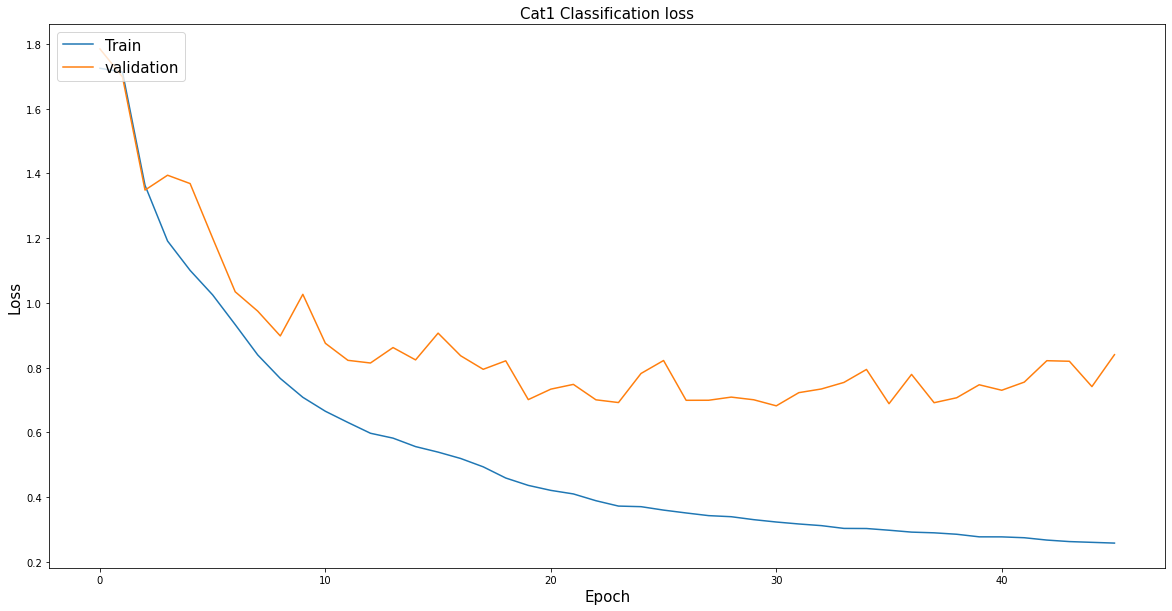

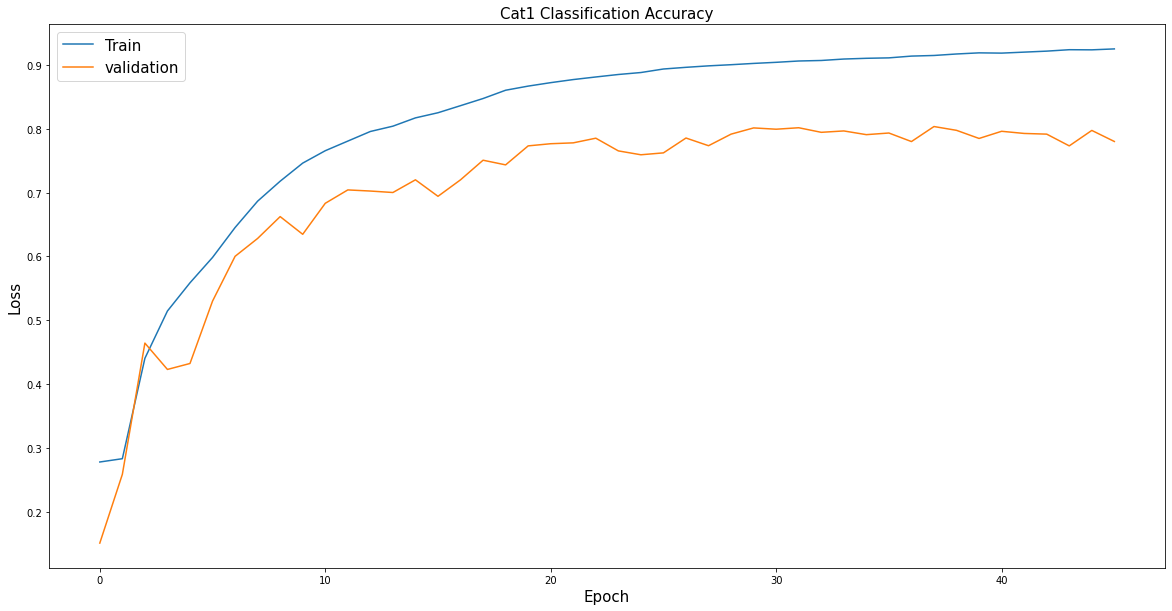

In [ ]:
# Plot training & validation loss values
plt.figure(figsize = (20, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Cat1 Classification loss', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.xlabel('Epoch', fontsize = 15)
plt.legend(['Train', 'validation'], loc='upper left', fontsize = 15)
plt.show();

# Plot training & validation accuracy values
plt.figure(figsize = (20, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Cat1 Classification Accuracy', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.xlabel('Epoch', fontsize = 15)
plt.legend(['Train', 'validation'], loc='upper left', fontsize = 15)
plt.show();

In [ ]:
lstm_test_acc = model.evaluate(sequences_test, y_test_enc1)
lstm_test_acc

313/313 [==============================] - 7s 20ms/step - loss: 0.8953 - accuracy: 0.7467


[0.8952557444572449, 0.7466999888420105]

### LSTM with Attention(Classification)

In [ ]:
class Attention(tf.keras.Model):
  def __init__(self, units):
    super(Attention, self).__init__()
    self.W1 = Dense(units)
    self.W2 = Dense(units)
    self.V = Dense(1)

  def call(self, values, query): # 단, key와 value는 같음
    # query shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # score 계산을 위해 뒤에서 할 덧셈을 위해서 차원을 변경해줍니다.
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
model_name = 'lstm_attention'


kargs = {'model_name' : model_name,
         'vocab_size' : 10000, ##빈번하게 등장하는 단어로 선정
         'embedding_dimension' : 128, ##임베딩 차원 수
         'dropout_rate' : 0.5, ## 드롭아웃 비율
         'lstm_dimension' : 256, ## LSTM 레이어 수
         'dense_dimension' : 256,
         'output_dimension' : 6} ## 출력값

class LSTM_Attention(tf.keras.Model):
    def __init__(self, **kargs):
        super(LSTM_Attention, self).__init__(name=kargs['model_name'])
        self.embedding = tf.keras.layers.Embedding(input_dim = kargs['vocab_size'], 
                                                   output_dim=kargs['embedding_dimension'], 
                                                   input_length=100, 
                                                   mask_zero=True)
        self.bilstm_layer = tf.keras.layers.Bidirectional(LSTM(kargs['lstm_dimension'],
                                                               return_sequences = True))
        self.bilstm_layer2 = tf.keras.layers.Bidirectional(LSTM(kargs['lstm_dimension'],
                                                                return_sequences=True,
                                                                return_state = True))
        self.fc1 = tf.keras.layers.Dense(units=kargs['dense_dimension'], 
                                         activation = tf.keras.activations.relu)
        self.dropout = tf.keras.layers.Dropout(kargs['dropout_rate'])
        self.fc2 = tf.keras.layers.Dense(units = kargs['output_dimension'], 
                                         activation = tf.keras.activations.softmax)
        self.attention = Attention(units=kargs['lstm_dimension'])
        
    def call(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = self.bilstm_layer(x)

        lstm, forward_h, forward_c, backward_h, backward_c = self.bilstm_layer2(x)
        state_h = Concatenate()([forward_h, backward_h]) # 은닉 상태
        state_c = Concatenate()([forward_c, backward_c]) # 셀 상태
        context_vector, attention_weights = self.attention(lstm, state_h)

        x = self.fc1(context_vector)
        x = self.dropout(x)
        x = self.fc2(x)

        return x
 

In [ ]:
model_name = "attention_lstm"

checkpoint_path = os.path.join(model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

        # Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
            
cp_callback = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 15)
# resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])

# tf.config.experimental_connect_to_cluster(resolver)
# tf.tpu.experimental.initialize_tpu_system(resolver)

# strategy = tf.distribute.TPUStrategy(resolver)

# with strategy.scope():
attention_lstm6 = LSTM_Attention(**kargs)
attention_lstm6.compile(optimizer = tf.keras.optimizers.Adam(1e-4),
                        loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                        metrics = [tf.keras.metrics.SparseCategoricalAccuracy(name = 'accuracy')])

history_attention = attention_lstm6.fit(sequences, y_train_enc1, 
                         epochs=50, 
                         batch_size=128,  
                         validation_split=0.2, 
                         callbacks=[es, cp_callback])

attention_lstm -- Folder create complete 

Epoch 1/50
231/231 [==============================] - 184s 739ms/step - loss: 1.4826 - accuracy: 0.3945 - val_loss: 1.3431 - val_accuracy: 0.4627

Epoch 00001: val_loss improved from inf to 1.34315, saving model to attention_lstm/weights.h5
Epoch 2/50
231/231 [==============================] - 167s 722ms/step - loss: 1.0629 - accuracy: 0.5747 - val_loss: 1.1007 - val_accuracy: 0.5733

Epoch 00002: val_loss improved from 1.34315 to 1.10067, saving model to attention_lstm/weights.h5
Epoch 3/50
231/231 [==============================] - 166s 719ms/step - loss: 0.7616 - accuracy: 0.7284 - val_loss: 0.8396 - val_accuracy: 0.7136

Epoch 00003: val_loss improved from 1.10067 to 0.83960, saving model to attention_lstm/weights.h5
Epoch 4/50
231/231 [==============================] - 166s 720ms/step - loss: 0.5938 - accuracy: 0.7992 - val_loss: 0.7187 - val_accuracy: 0.7534

Epoch 00004: val_loss improved from 0.83960 to 0.71870, saving model to attenti

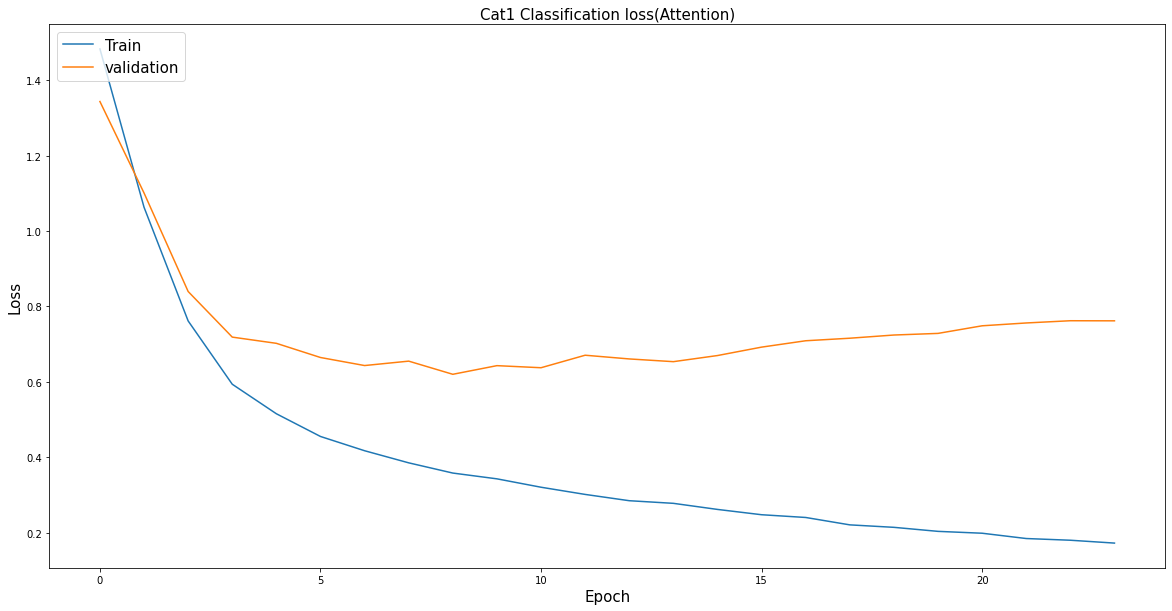

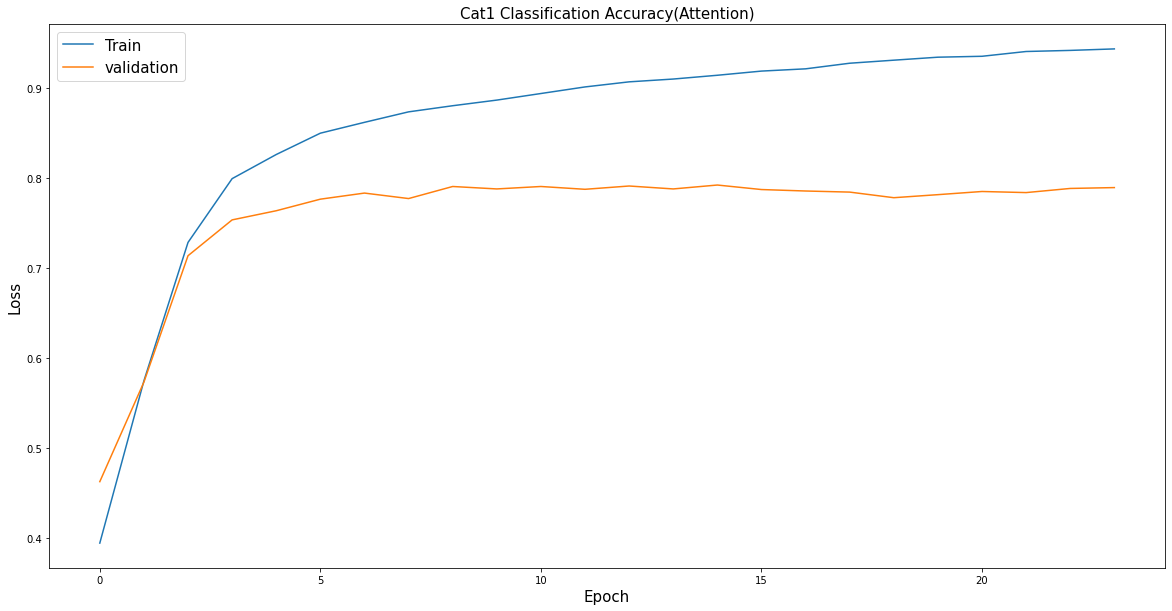

In [ ]:
# Plot training & validation loss values
plt.figure(figsize = (20, 10))
plt.plot(history_attention.history['loss'])
plt.plot(history_attention.history['val_loss'])
plt.title('Cat1 Classification loss(Attention)', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.xlabel('Epoch', fontsize = 15)
plt.legend(['Train', 'validation'], loc='upper left', fontsize = 15)
plt.show();

# Plot training & validation accuracy values
plt.figure(figsize = (20, 10))
plt.plot(history_attention.history['accuracy'])
plt.plot(history_attention.history['val_accuracy'])
plt.title('Cat1 Classification Accuracy(Attention)', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.xlabel('Epoch', fontsize = 15)
plt.legend(['Train', 'validation'], loc='upper left', fontsize = 15)
plt.show();

In [ ]:
attention_test_acc = attention_lstm6.evaluate(sequences_test, y_test_enc1)
attention_test_acc

313/313 [==============================] - 44s 141ms/step - loss: 0.8059 - accuracy: 0.7592


[0.8058871626853943, 0.7591999769210815]

### LSTM with Glove

In [ ]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kikikiekf","key":"7703b5aa7800af7723aba75c99cb6a6f"}'}

In [ ]:
ls -1ha kaggle.json

kaggle.json


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning 이 일어나지 않도록 
!chmod 600 ~/.kaggle/kaggle.json
# 본인이 참가한 모든 대회 보기 
!kaggle competitions list

ref                                                  deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
contradictory-my-dear-watson                         2030-07-01 23:59:00  Getting Started     Prizes        231           False  
gan-getting-started                                  2030-07-01 23:59:00  Getting Started     Prizes        393           False  
tpu-getting-started                                  2030-06-03 23:59:00  Getting Started  Knowledge       1032           False  
digit-recognizer                                     2030-01-01 00:00:00  Getting Started  Knowledge       6694           False  
titanic                                              2030-01-01 00:00:00  Getting Started  Knowledge      57161           False  
house-prices-advanced-regression-techniques          2030-01-01 00:00:00  Getting Started 

In [ ]:
! kaggle datasets download -d authman/pickled-glove840b300d-for-10sec-loading

 99% 2.32G/2.33G [00:29<00:00, 81.0MB/s]
100% 2.33G/2.33G [00:29<00:00, 85.5MB/s]


In [ ]:
!unzip pickled-glove840b300d-for-10sec-loading.zip

Archive:  pickled-glove840b300d-for-10sec-loading.zip
  inflating: glove.840B.300d.pkl     


In [ ]:
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense, GlobalMaxPooling1D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle

In [ ]:
## 사전학습된 Glove 임베딩 방법 호출
GLOVE_EMBEDDING_PATH = '/content/glove.840B.300d.pkl'

def load_embeddings(path):
    with open(path,'rb') as f:
        emb_arr = pickle.load(f)
    return emb_arr

def build_matrix(word_index, path):
    embedding_index = load_embeddings(path)
    embedding_matrix = np.zeros((len(word_index) + 1, 300))
    unknown_words = []
    
    for word, i in word_index.items():
        try:
            embedding_matrix[i] = embedding_index[word]
        except KeyError:
            unknown_words.append(word)
    return embedding_matrix, unknown_words

glove_matrix, unknown_words_glove = build_matrix(word_index, GLOVE_EMBEDDING_PATH)
print('number unknown words (glove): ', len(unknown_words_glove))

number unknown words (glove):  6515


In [ ]:
X_train1

,index,Text,length,word_len,Cat1,Cat2
0,0,description photo product needs changed indica...,84,11,grocery gourmet food,meat poultry
1,1,great book well thought easily imagine events ...,167,25,toys games,games
2,2,first year teacher teaching th grade special r...,320,49,toys games,games
3,3,got book bookfair school looking something sum...,299,42,toys games,games
4,4,hi martine redman created puzzle briarpatch us...,460,63,toys games,puzzles
...,...,...,...,...,...,...
36939,39995,even convenient find really small store tiny a...,94,14,beauty,makeup
36940,39996,wore next day eating chinese take ankles went ...,87,15,health personal care,medical supplies equipment
36941,39997,ok product really stay fog free long useful co...,61,11,beauty,tools accessories
36942,39998,glitter body lotion offers tremendous sparkle ...,299,42,beauty,skin care


In [ ]:
token = Tokenizer(num_words=10000) ## 빈도수가 높은 10,000개의 단어
token.fit_on_texts(X_train1['Text'])
sequences = token.texts_to_sequences(X_train1['Text'])
sequences = pad_sequences(sequences, maxlen= 300, padding = 'post')
word_index = token.word_index
vocab_size = len(word_index) + 1
sequences_test = token.texts_to_sequences(X_test['Text'])
sequences_test = pad_sequences(sequences_test, maxlen= 300, padding = 'post')

In [ ]:
sequences.shape, sequences_test.shape, vocab_size

((36944, 300), (10000, 300), 44546)

In [ ]:
# first model
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])

tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

strategy = tf.distribute.TPUStrategy(resolver)

with strategy.scope():
    model1 = Sequential()

    embeddings = Embedding(vocab_size, 300, weights=[glove_matrix], input_length=300, trainable=False)

    model1.add(embeddings)
    model1.add(Bidirectional(LSTM(256, return_sequences=True, dropout=0.5, recurrent_dropout=0.5)))
    model1.add(GlobalMaxPooling1D())
    model1.add(Dense(6, activation='softmax')) 

    model1.compile(loss='sparse_categorical_crossentropy', optimizer = Adam(1e-4), metrics=['accuracy'])
    model1.summary()

INFO:tensorflow:Initializing the TPU system: grpc://10.48.105.170:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.48.105.170:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 300, 300)          13363800  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 300, 512)          1140736   
_________________________________________________________________
global_max_pooling1d (Global (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 6)                 3078      
Total params: 14,507,614
Trainable params: 1,143,814
Non-trainable params: 13,363,800
_________________________________________________________________


In [ ]:
model_name = "glove_6"


checkpoint_path = os.path.join(model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

        # Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
            
cp_callback = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 15)

history_glove = model1.fit(sequences, y_train_enc1, batch_size=128, epochs=50, validation_split = 0.2, callbacks=[cp_callback, es], verbose=1)

glove_6 -- Folder create complete 

Epoch 1/50


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 300) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 1) dtype=float32>]
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 300) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 1) dtype=float32>]


231/231 [==============================] - ETA: 0s - loss: 1.0728 - accuracy: 0.6073

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 300) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 1) dtype=float32>]


231/231 [==============================] - 39s 130ms/step - loss: 1.0728 - accuracy: 0.6073 - val_loss: 0.7793 - val_accuracy: 0.7253

Epoch 00001: val_loss improved from inf to 0.77931, saving model to glove_6/weights.h5
Epoch 2/50
231/231 [==============================] - 24s 104ms/step - loss: 0.6042 - accuracy: 0.7869 - val_loss: 0.6476 - val_accuracy: 0.7698

Epoch 00002: val_loss improved from 0.77931 to 0.64759, saving model to glove_6/weights.h5
Epoch 3/50
231/231 [==============================] - 24s 103ms/step - loss: 0.5374 - accuracy: 0.8101 - val_loss: 0.6027 - val_accuracy: 0.7836

Epoch 00003: val_loss improved from 0.64759 to 0.60267, saving model to glove_6/weights.h5
Epoch 4/50
231/231 [==============================] - 24s 103ms/step - loss: 0.5085 - accuracy: 0.8185 - val_loss: 0.5818 - val_accuracy: 0.7942

Epoch 00004: val_loss improved from 0.60267 to 0.58184, saving model to glove_6/weights.h5
Epoch 5/50
231/231 [==============================] - 24s 104ms/ste

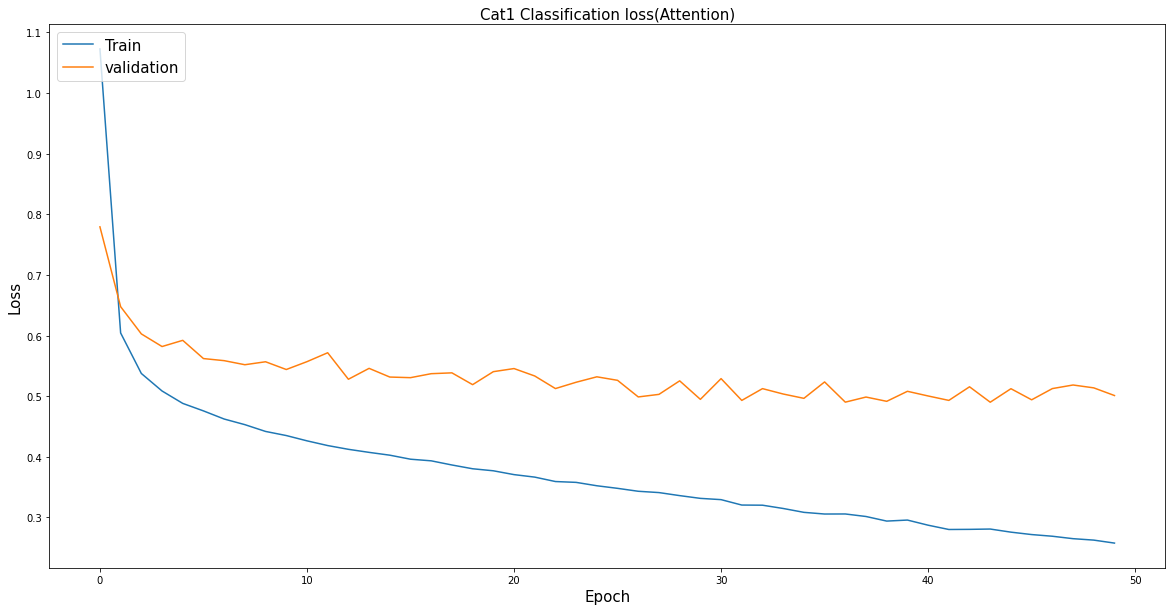

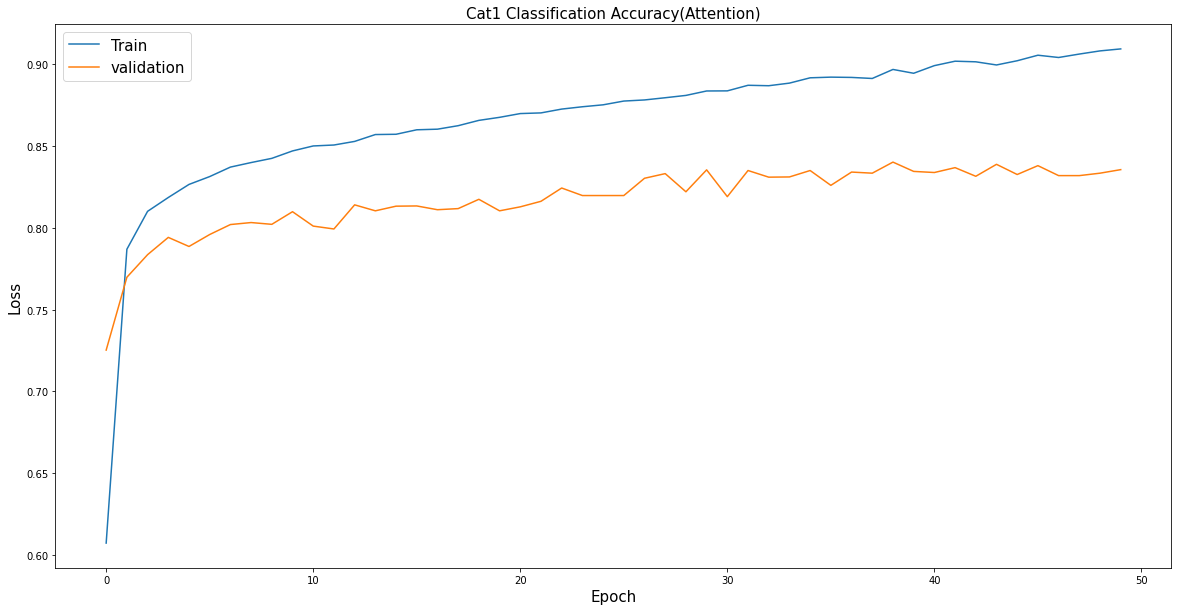

In [ ]:
# Plot training & validation loss values
plt.figure(figsize = (20, 10))
plt.plot(history_glove.history['loss'])
plt.plot(history_glove.history['val_loss'])
plt.title('Cat1 Classification loss(Attention)', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.xlabel('Epoch', fontsize = 15)
plt.legend(['Train', 'validation'], loc='upper left', fontsize = 15)
plt.show();

# Plot training & validation accuracy values
plt.figure(figsize = (20, 10))
plt.plot(history_glove.history['accuracy'])
plt.plot(history_glove.history['val_accuracy'])
plt.title('Cat1 Classification Accuracy(Attention)', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.xlabel('Epoch', fontsize = 15)
plt.legend(['Train', 'validation'], loc='upper left', fontsize = 15)
plt.show();

In [ ]:
glove_test_acc = model1.evaluate(sequences_test, y_test_enc1)
glove_test_acc

313/313 [==============================] - 11s 32ms/step - loss: 0.5580 - accuracy: 0.8105


[0.5579797029495239, 0.8104999661445618]

위의 모델들보다 사전학습된 Glove가 과적합이 일어나지 않고 성능이 꽤나 높게 나오는 것을 볼 수 있다. 

### BERT

In [ ]:
from transformers import BertTokenizer, TFBertModel, BertModel
from transformers.models import speech_to_text

#random seed 고정
tf.random.set_seed(411)
np.random.seed(411)
BATCH_SIZE = 64
VALID_SPLIT = 0.2
MAX_LEN=300

In [ ]:
tokenizer=BertTokenizer.from_pretrained('bert-base-multilingual-cased',  cache_dir='bert_ckpt', do_lower_case=False)

def bert_tokenizer(sent, MAX_LEN):
    
    encoded_dict=tokenizer.encode_plus(
    text = sent, 
    add_special_tokens=True, 
    max_length=MAX_LEN, 
    pad_to_max_length=True, 
    return_attention_mask=True,
    truncation = True)
    
    input_id=encoded_dict['input_ids']
    attention_mask=encoded_dict['attention_mask']
    token_type_id = encoded_dict['token_type_ids']
    
    return input_id, attention_mask, token_type_id

input_ids =[]
attention_masks =[]
token_type_ids =[]
train_data_labels = []


for train_sent, train_label in zip(X_train['Text'], y_train_enc1):
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer(train_sent, MAX_LEN=MAX_LEN)
        
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        #########################################
        train_data_labels.append(train_label)
        
    except Exception as e:
        print(e)
        print(train_sent)
        pass

train_input_ids=np.array(input_ids, dtype=int)
train_attention_masks=np.array(attention_masks, dtype=int)
train_token_type_ids=np.array(token_type_ids, dtype=int)
###########################################################
train_inputs=(train_input_ids, train_attention_masks, train_token_type_ids)
train_labels=np.asarray(train_data_labels, dtype=np.int32)

In [ ]:
class TFBertClassifier(tf.keras.Model):
    def __init__(self, model_name, dir_path, num_class):
        super(TFBertClassifier, self).__init__()

        self.bert = TFBertModel.from_pretrained(model_name, cache_dir=dir_path)
        self.dropout = tf.keras.layers.Dropout(self.bert.config.hidden_dropout_prob)
        self.classifier = tf.keras.layers.Dense(num_class, 
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(self.bert.config.initializer_range), 
                                                name="classifier")
        
    def call(self, inputs, attention_mask=None, token_type_ids=None, training=False):
        
        #outputs 값: # sequence_output, pooled_output, (hidden_states), (attentions)
        outputs = self.bert(inputs, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs[1] 
        pooled_output = self.dropout(pooled_output, training=training)
        logits = self.classifier(pooled_output)

        return logits

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])

tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

strategy = tf.distribute.TPUStrategy(resolver)

with strategy.scope(): ## TPU 설정
    cls_model = TFBertClassifier(model_name='bert-base-multilingual-cased',
                                        dir_path='bert_ckpt',
                                        num_class=6)

        # 학습 준비하기
    optimizer = tf.keras.optimizers.Adam(3e-6)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
    cls_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

model_name = "bert_classifier"

# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_loss', min_delta=0.0001,patience=10, restore_best_weights=True)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)\

checkpoint_path = os.path.join(model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

# 학습과 eval 시작
history_bert = cls_model.fit(train_inputs, train_labels, epochs=50, batch_size=64,
                    validation_split = VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

INFO:tensorflow:Initializing the TPU system: grpc://10.48.105.170:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.48.105.170:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


bert_classifier -- Folder create complete 

Epoch 1/50


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 300) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 300) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 300) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None, 1) dtype=int32>]


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 300) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 300) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 300) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None, 1) dtype=int32>]


462/462 [==============================] - ETA: 0s - loss: 1.0189 - accuracy: 0.6255

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 300) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 300) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 300) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None, 1) dtype=int32>]


462/462 [==============================] - 289s 346ms/step - loss: 1.0189 - accuracy: 0.6255 - val_loss: 0.7883 - val_accuracy: 0.7223

Epoch 00001: val_loss improved from inf to 0.78829, saving model to bert_classifier/weights.h5
Epoch 2/50
462/462 [==============================] - 95s 206ms/step - loss: 0.5898 - accuracy: 0.7960 - val_loss: 0.6554 - val_accuracy: 0.7729

Epoch 00002: val_loss improved from 0.78829 to 0.65542, saving model to bert_classifier/weights.h5
Epoch 3/50
462/462 [==============================] - 95s 205ms/step - loss: 0.4977 - accuracy: 0.8305 - val_loss: 0.6135 - val_accuracy: 0.7902

Epoch 00003: val_loss improved from 0.65542 to 0.61346, saving model to bert_classifier/weights.h5
Epoch 4/50
462/462 [==============================] - 95s 206ms/step - loss: 0.4396 - accuracy: 0.8513 - val_loss: 0.5857 - val_accuracy: 0.8016

Epoch 00004: val_loss improved from 0.61346 to 0.58566, saving model to bert_classifier/weights.h5
Epoch 5/50
462/462 [==============

In [ ]:
input_ids =[]
attention_masks =[]
token_type_ids =[]
test_data_labels = []


for test_sent, test_label in zip(X_test['Text'], y_test_enc1):
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer(test_sent, MAX_LEN=MAX_LEN)
        
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        #########################################
        test_data_labels.append(test_label)
    except Exception as e:
        print(e)
        print(test_sent)
        pass
    
test_input_ids=np.array(input_ids, dtype=int)
test_attention_masks=np.array(attention_masks, dtype=int)
test_token_type_ids=np.array(token_type_ids, dtype=int)
###########################################################
test_inputs=(test_input_ids, test_attention_masks, test_token_type_ids)
test_labels = np.asarray(test_data_labels, dtype = np.int32)

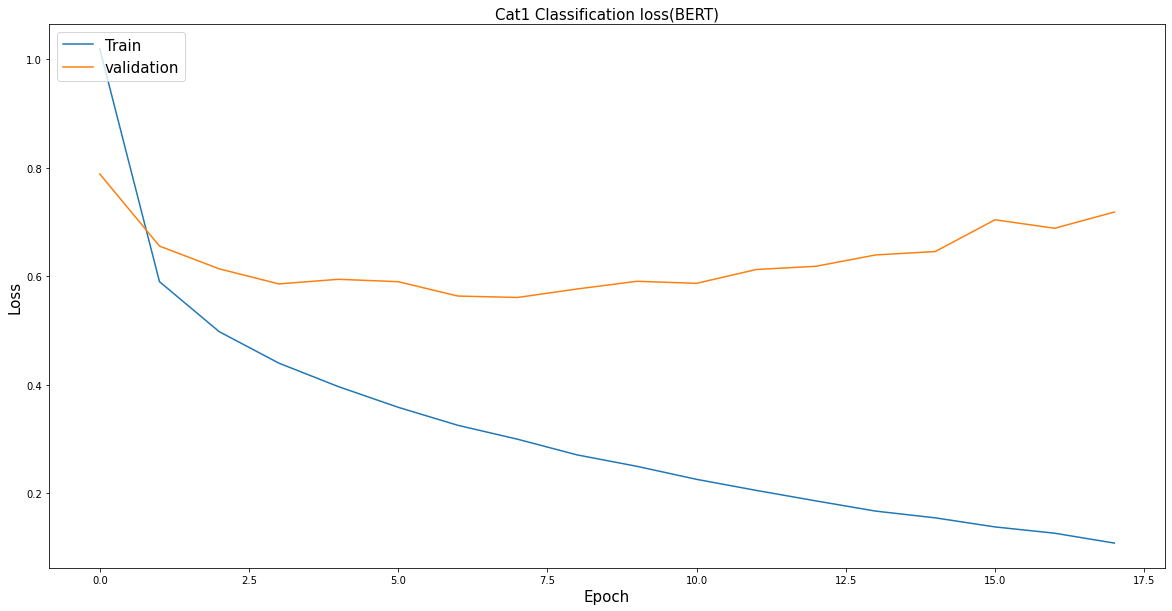

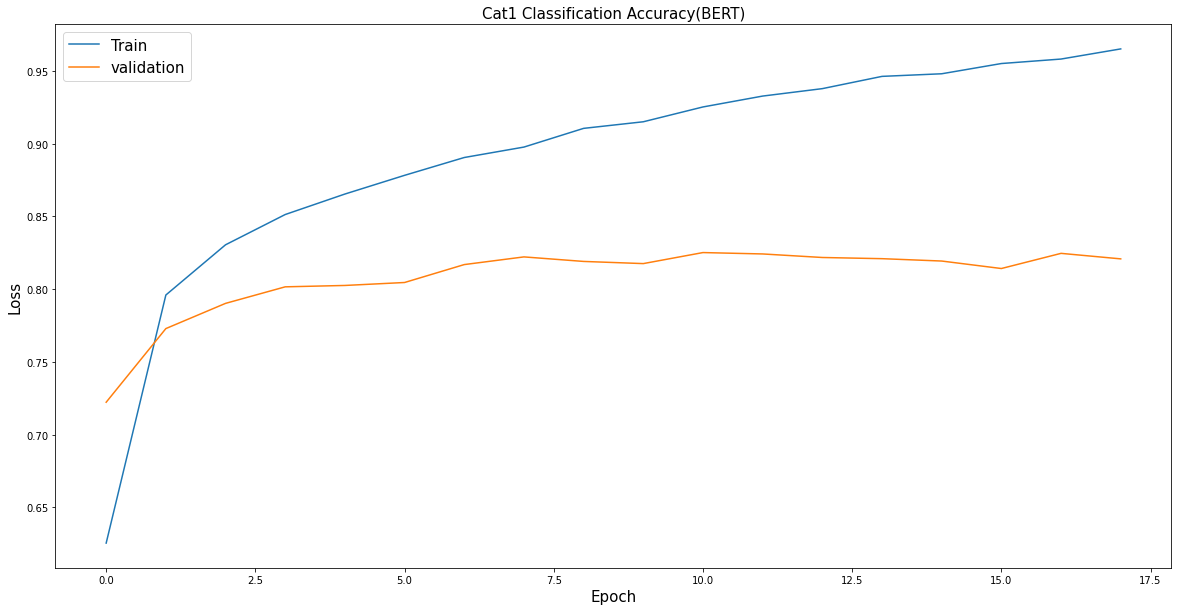

In [ ]:
# Plot training & validation loss values
plt.figure(figsize = (20, 10))
plt.plot(history_bert.history['loss'])
plt.plot(history_bert.history['val_loss'])
plt.title('Cat1 Classification loss(BERT)', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.xlabel('Epoch', fontsize = 15)
plt.legend(['Train', 'validation'], loc='upper left', fontsize = 15)
plt.show();

# Plot training & validation accuracy values
plt.figure(figsize = (20, 10))
plt.plot(history_bert.history['accuracy'])
plt.plot(history_bert.history['val_accuracy'])
plt.title('Cat1 Classification Accuracy(BERT)', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.xlabel('Epoch', fontsize = 15)
plt.legend(['Train', 'validation'], loc='upper left', fontsize = 15)
plt.show();

In [ ]:
bert_acc = cls_model.fit(test_inputs, test_labels)
bert_acc

313/313 [==============================] - 133s 276ms/step - loss: 0.6310 - accuracy: 0.7831


### LSTM with Attention(Glove)

In [ ]:
class Attention(tf.keras.Model):
  def __init__(self, units):
    super(Attention, self).__init__()
    self.W1 = Dense(units)
    self.W2 = Dense(units)
    self.V = Dense(1)

  def call(self, values, query): # 단, key와 value는 같음
    # query shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # score 계산을 위해 뒤에서 할 덧셈을 위해서 차원을 변경해줍니다.
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
model_name = 'lstm_attention_glove'


kargs = {'model_name' : model_name,
         'vocab_size' : vocab_size,
         'embedding_dimension' : 300,
         'dropout_rate' : 0.6,
         'lstm_dimension' : 256,
         'dense_dimension' : 256,
         'output_dimension' : 6,
         'weight' : glove_matrix}

class LSTM_Attention(tf.keras.Model):
    def __init__(self, **kargs):
        super(LSTM_Attention, self).__init__(name=kargs['model_name'])
        self.embedding = tf.keras.layers.Embedding(input_dim = kargs['vocab_size'], 
                                                   output_dim=kargs['embedding_dimension'], 
                                                   input_length=300,
                                                   weights = [kargs['weight']], 
                                                   trainable = False)
        
        self.bilstm_layer = tf.keras.layers.Bidirectional(LSTM(kargs['lstm_dimension'],
                                                               return_sequences = True))
        self.bilstm_layer2 = tf.keras.layers.Bidirectional(LSTM(kargs['lstm_dimension'],
                                                                return_sequences=True,
                                                                return_state = True))
        # self.gmp = tf.keras.layers.GlobalMaxPooling1D()
        self.fc1 = tf.keras.layers.Dense(units=kargs['dense_dimension'], 
                                         activation = tf.keras.activations.relu)
        self.dropout = tf.keras.layers.Dropout(kargs['dropout_rate'])
        self.fc2 = tf.keras.layers.Dense(units = kargs['output_dimension'], 
                                         activation = tf.keras.activations.softmax)
        self.attention = Attention(units=kargs['lstm_dimension'])
        
    def call(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = self.bilstm_layer(x)

        lstm, forward_h, forward_c, backward_h, backward_c = self.bilstm_layer2(x)
        state_h = Concatenate()([forward_h, backward_h]) # 은닉 상태
        state_c = Concatenate()([forward_c, backward_c]) # 셀 상태
        context_vector, attention_weights = self.attention(lstm, state_h)
        
        x = self.fc1(context_vector)
        x = self.dropout(x)
        x = self.fc2(x)

        return x
 

In [ ]:
model_name = "attention_lstm_glove"

checkpoint_path = os.path.join(model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

        # Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
            
cp_callback = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 15)

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])

tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

strategy = tf.distribute.TPUStrategy(resolver)

with strategy.scope():
    attention_lstm6_glove = LSTM_Attention(**kargs)
    attention_lstm6_glove.compile(optimizer = tf.keras.optimizers.Adam(1e-3),
                            loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                            metrics = [tf.keras.metrics.SparseCategoricalAccuracy(name = 'accuracy')])

history_att_glove = attention_lstm6_glove.fit(sequences, y_train_enc1, 
                         epochs=50, 
                         batch_size=128,  
                         validation_split=0.2, 
                         callbacks=[es, cp_callback])

attention_lstm_glove -- Folder create complete 



INFO:tensorflow:Initializing the TPU system: grpc://10.48.105.170:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.48.105.170:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Epoch 1/50


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 300) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 1) dtype=float32>]
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 300) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 1) dtype=float32>]


231/231 [==============================] - ETA: 0s - loss: 1.5915 - accuracy: 0.3563

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 300) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 1) dtype=float32>]


231/231 [==============================] - 80s 279ms/step - loss: 1.5915 - accuracy: 0.3563 - val_loss: 1.4624 - val_accuracy: 0.4117

Epoch 00001: val_loss improved from inf to 1.46236, saving model to attention_lstm_glove/weights.h5
Epoch 2/50
231/231 [==============================] - 54s 235ms/step - loss: 1.3407 - accuracy: 0.4832 - val_loss: 1.3069 - val_accuracy: 0.5010

Epoch 00002: val_loss improved from 1.46236 to 1.30688, saving model to attention_lstm_glove/weights.h5
Epoch 3/50
231/231 [==============================] - 55s 236ms/step - loss: 1.2168 - accuracy: 0.5436 - val_loss: 1.2288 - val_accuracy: 0.5339

Epoch 00003: val_loss improved from 1.30688 to 1.22880, saving model to attention_lstm_glove/weights.h5
Epoch 4/50
231/231 [==============================] - 56s 241ms/step - loss: 1.1258 - accuracy: 0.5805 - val_loss: 1.1054 - val_accuracy: 0.6018

Epoch 00004: val_loss improved from 1.22880 to 1.10536, saving model to attention_lstm_glove/weights.h5
Epoch 5/50
231/

In [ ]:
attention_glove = attention_lstm6_glove.evaluate(sequences_test, y_test_enc1)
attention_glove

313/313 [==============================] - 14s 40ms/step - loss: 0.8605 - accuracy: 0.7103


[0.8605125546455383, 0.7102999687194824]

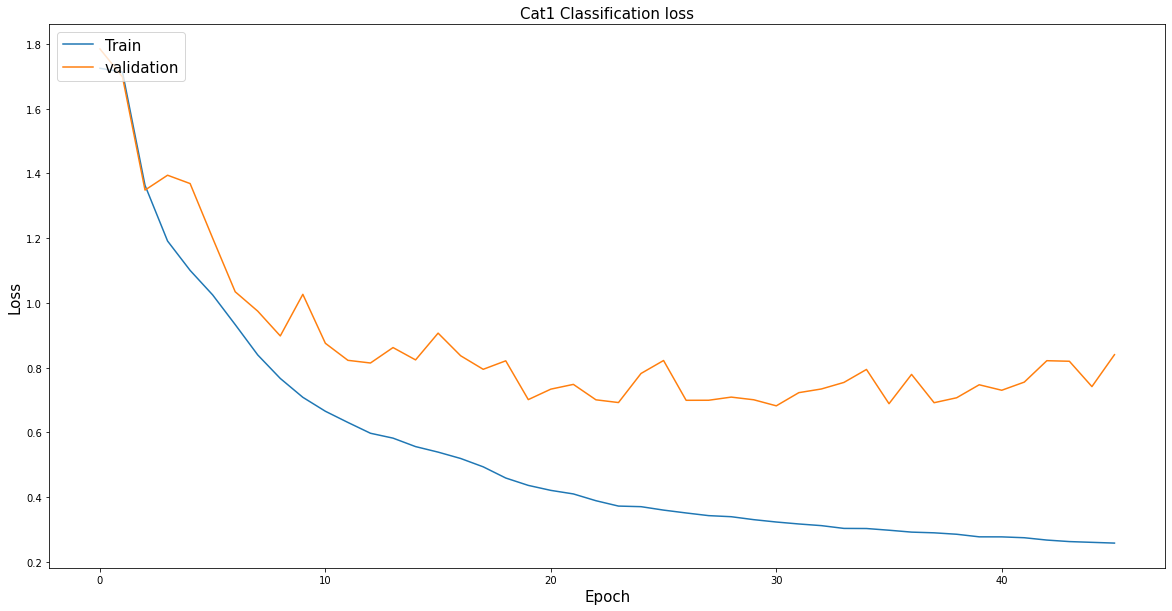

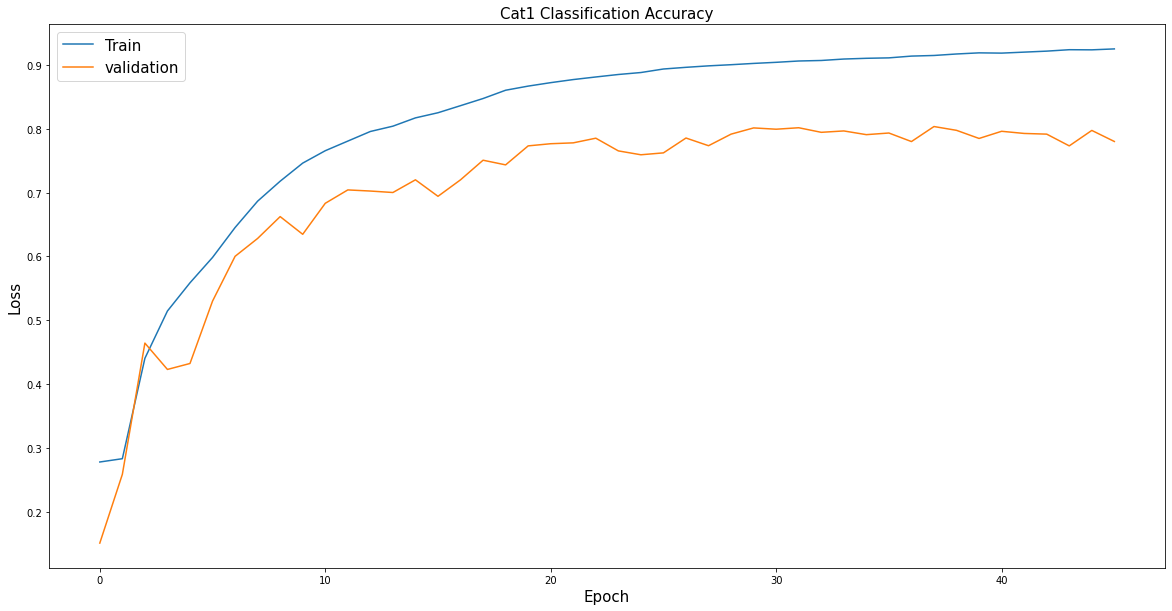

In [ ]:
# Plot training & validation loss values
plt.figure(figsize = (20, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Cat1 Classification loss', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.xlabel('Epoch', fontsize = 15)
plt.legend(['Train', 'validation'], loc='upper left', fontsize = 15)
plt.show();

# Plot training & validation accuracy values
plt.figure(figsize = (20, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Cat1 Classification Accuracy', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.xlabel('Epoch', fontsize = 15)
plt.legend(['Train', 'validation'], loc='upper left', fontsize = 15)
plt.show();

이전의 프로젝트를 진행하면서, 요약문 추출에서 라벨링이 어느 정도 정형화되어 있다면 성능이 좋지 않을까라는 생각을 했었다. 그래서 그것을 바탕으로 Sequence to Sequence 모델을 구현하여 카테고리를 분류하는 모델을 구현해보겠다.

### Seq2Seq 형태의 LSTM with Attention

In [ ]:
X_train, y_train1

(                                                    Text  length  word_len
 0      description photo product needs changed indica...      84        11
 1      great book well thought easily imagine events ...     167        25
 2      first year teacher teaching th grade special r...     320        49
 3      got book bookfair school looking something sum...     299        42
 4      hi martine redman created puzzle briarpatch us...     460        63
 ...                                                  ...     ...       ...
 39995  even convenient find really small store tiny a...      94        14
 39996  wore next day eating chinese take ankles went ...      87        15
 39997  ok product really stay fog free long useful co...      61        11
 39998  glitter body lotion offers tremendous sparkle ...     299        42
 39999  disappointed scent fragrance smells cheap need...      84        12
 
 [36944 rows x 3 columns],                        Cat1
 0      grocery gourmet food
 1

In [ ]:
y_test2

,Cat2,decoder_input2,decoder_target2
0,cats,sos cats,cats eos
1,bunny rabbit central,sos bunny rabbit central,bunny rabbit central eos
2,health care,sos health care,health care eos
3,snack food,sos snack food,snack food eos
4,dogs,sos dogs,dogs eos
...,...,...,...
9995,health care,sos health care,health care eos
9996,fish aquatic pets,sos fish aquatic pets,fish aquatic pets eos
9997,dogs,sos dogs,dogs eos
9998,dogs,sos dogs,dogs eos


In [ ]:
X_train1['Cat1'] = X_train1['Cat1'].apply(lambda x : x.replace(' ','')) ##띄어쓰기가 있으면 단어 자체가 분할이 이루어져 전부 띄어쓰기를 제거해줌
X_train1['Cat2'] = X_train1['Cat2'].apply(lambda x : x.replace(' ','')) ##띄어쓰기가 있으면 단어 자체가 분할이 이루어져 전부 띄어쓰기를 제거해줌
y_test1['Cat1'] = y_test1['Cat1'].apply(lambda x : x.replace(' ','')) ##띄어쓰기가 있으면 단어 자체가 분할이 이루어져 전부 띄어쓰기를 제거해줌
y_test2['Cat2'] = y_test2['Cat2'].apply(lambda x : x.replace(' ','')) ##띄어쓰기가 있으면 단어 자체가 분할이 이루어져 전부 띄어쓰기를 제거해줌
X_train1, y_test1

(       index  ...               decoder_target2
 0          0  ...               meatpoultry eos
 1          1  ...                     games eos
 2          2  ...                     games eos
 3          3  ...                     games eos
 4          4  ...                   puzzles eos
 ...      ...  ...                           ...
 36939  39995  ...                    makeup eos
 36940  39996  ...  medicalsuppliesequipment eos
 36941  39997  ...          toolsaccessories eos
 36942  39998  ...                  skincare eos
 36943  39999  ...                 fragrance eos
 
 [36944 rows x 10 columns],
                     Cat1          decoder_input1         decoder_target1
 0            petsupplies         sos petsupplies         petsupplies eos
 1            petsupplies         sos petsupplies         petsupplies eos
 2     healthpersonalcare  sos healthpersonalcare  healthpersonalcare eos
 3     grocerygourmetfood  sos grocerygourmetfood  grocerygourmetfood eos
 4          

In [ ]:
X_train1

,index,Text,length,word_len,Cat1,Cat2,decoder_input1,decoder_input2,decoder_target1,decoder_target2
0,0,description photo product needs changed indica...,84,11,grocerygourmetfood,meatpoultry,sos grocerygourmetfood,sos meatpoultry,grocerygourmetfood eos,meatpoultry eos
1,1,great book well thought easily imagine events ...,167,25,toysgames,games,sos toysgames,sos games,toysgames eos,games eos
2,2,first year teacher teaching th grade special r...,320,49,toysgames,games,sos toysgames,sos games,toysgames eos,games eos
3,3,got book bookfair school looking something sum...,299,42,toysgames,games,sos toysgames,sos games,toysgames eos,games eos
4,4,hi martine redman created puzzle briarpatch us...,460,63,toysgames,puzzles,sos toysgames,sos puzzles,toysgames eos,puzzles eos
...,...,...,...,...,...,...,...,...,...,...
36939,39995,even convenient find really small store tiny a...,94,14,beauty,makeup,sos beauty,sos makeup,beauty eos,makeup eos
36940,39996,wore next day eating chinese take ankles went ...,87,15,healthpersonalcare,medicalsuppliesequipment,sos healthpersonalcare,sos medicalsuppliesequipment,healthpersonalcare eos,medicalsuppliesequipment eos
36941,39997,ok product really stay fog free long useful co...,61,11,beauty,toolsaccessories,sos beauty,sos toolsaccessories,beauty eos,toolsaccessories eos
36942,39998,glitter body lotion offers tremendous sparkle ...,299,42,beauty,skincare,sos beauty,sos skincare,beauty eos,skincare eos


In [ ]:
for i in X_train1[X_train1['Text'] == ''].index:
    X_train1 = X_train1.drop(i, axis = 0)

X_train1[X_train1['Text'] =='']

,index,Text,length,word_len,Cat1,Cat2,decoder_input1,decoder_input2,decoder_target1,decoder_target2


In [ ]:
# X_train = X_train[X_train['Text'].apply(lambda x: len(x.split()) <= 100)]

# print('전체 데이터 수 : ', len(X_train))

In [ ]:
X_train1['decoder_input1'] = X_train1['Cat1'].apply(lambda x : 'sos ' + x) #시작 단어 표시
X_train1['decoder_input2'] = X_train1['Cat2'].apply(lambda x : 'sos ' + x)  #시작 단어 표시

X_train1['decoder_target1'] = X_train1['Cat1'].apply(lambda x : x + ' eos') #끝 단어 표시
X_train1['decoder_target2'] = X_train1['Cat2'].apply(lambda x : x + ' eos') #끝 단어 표시

X_train1

,index,Text,length,word_len,Cat1,Cat2,decoder_input1,decoder_input2,decoder_target1,decoder_target2
0,0,description photo product needs changed indica...,84,11,grocerygourmetfood,meatpoultry,sos grocerygourmetfood,sos meatpoultry,grocerygourmetfood eos,meatpoultry eos
1,1,great book well thought easily imagine events ...,167,25,toysgames,games,sos toysgames,sos games,toysgames eos,games eos
2,2,first year teacher teaching th grade special r...,320,49,toysgames,games,sos toysgames,sos games,toysgames eos,games eos
3,3,got book bookfair school looking something sum...,299,42,toysgames,games,sos toysgames,sos games,toysgames eos,games eos
4,4,hi martine redman created puzzle briarpatch us...,460,63,toysgames,puzzles,sos toysgames,sos puzzles,toysgames eos,puzzles eos
...,...,...,...,...,...,...,...,...,...,...
36939,39995,even convenient find really small store tiny a...,94,14,beauty,makeup,sos beauty,sos makeup,beauty eos,makeup eos
36940,39996,wore next day eating chinese take ankles went ...,87,15,healthpersonalcare,medicalsuppliesequipment,sos healthpersonalcare,sos medicalsuppliesequipment,healthpersonalcare eos,medicalsuppliesequipment eos
36941,39997,ok product really stay fog free long useful co...,61,11,beauty,toolsaccessories,sos beauty,sos toolsaccessories,beauty eos,toolsaccessories eos
36942,39998,glitter body lotion offers tremendous sparkle ...,299,42,beauty,skincare,sos beauty,sos skincare,beauty eos,skincare eos


In [ ]:
y_test1['decoder_input1'] = y_test1['Cat1'].apply(lambda x : 'sos ' + x) #시작 단어 표시
y_test2['decoder_input2'] = y_test2['Cat2'].apply(lambda x : 'sos ' + x) #시작 단어 표시

y_test1['decoder_target1'] = y_test1['Cat1'].apply(lambda x : x + ' eos') #끝 단어 표시
y_test2['decoder_target2'] = y_test2['Cat2'].apply(lambda x : x + ' eos') #끝 단어 표시

y_test1, y_test2

(                    Cat1          decoder_input1         decoder_target1
 0            petsupplies         sos petsupplies         petsupplies eos
 1            petsupplies         sos petsupplies         petsupplies eos
 2     healthpersonalcare  sos healthpersonalcare  healthpersonalcare eos
 3     grocerygourmetfood  sos grocerygourmetfood  grocerygourmetfood eos
 4            petsupplies         sos petsupplies         petsupplies eos
 ...                  ...                     ...                     ...
 9995  healthpersonalcare  sos healthpersonalcare  healthpersonalcare eos
 9996         petsupplies         sos petsupplies         petsupplies eos
 9997         petsupplies         sos petsupplies         petsupplies eos
 9998         petsupplies         sos petsupplies         petsupplies eos
 9999  healthpersonalcare  sos healthpersonalcare  healthpersonalcare eos
 
 [10000 rows x 3 columns],
                           Cat2  ...               decoder_target2
 0              

In [ ]:
encoder_input = np.array(X_train1['Text']) #numpy를 이용하여 배열 전환
decoder_input1 = np.array(X_train1['decoder_input1']) #numpy를 이용하여 배열 전환
decoder_input2 = np.array(X_train1['decoder_input2']) #numpy를 이용하여 배열 전환
decoder_target1 = np.array(X_train1['decoder_target1']) #numpy를 이용하여 배열 전환
decoder_target2 = np.array(X_train1['decoder_target2']) #numpy를 이용하여 배열 전환

In [ ]:
test_encoder_input = np.array(X_test['Text']) #numpy를 이용하여 배열 전환
test_decoder_input1 = np.array(y_test1['decoder_input1']) #numpy를 이용하여 배열 전환
test_decoder_target1 = np.array(y_test1['decoder_target1']) #numpy를 이용하여 배열 전환

test_decoder_input2 = np.array(y_test2['decoder_input2']) #numpy를 이용하여 배열 전환
test_decoder_target2 = np.array(y_test2['decoder_target2']) #numpy를 이용하여 배열 전환

In [ ]:
test_encoder_input, test_decoder_input1, test_decoder_target1

(array(['installed weeks far works great chubby collie old black lab going easily easy install hanging little closing seems working supposed clear door disappointed',
        'bunny hard time eating hay dry small chew',
        'would never million years guessed little thing capable much whoever invented goddamn genius fantastic especially get knotted easily back thing make cry',
        ...,
        'works great needs better way attach made ow long stap two clips slip around back seat bed works much better',
        'absolutely loves thing dice green beans carrots usually takes mins get stuff gets excercise healthy treats quiet asks everynight around something happened one could find cost would buy daughter westie give crap though',
        'hurt neck went rehab exercises using therabands strengthen areas around neck sold bands high cost went online searched theraband found amazon bought every single resistance bands colors represent resistance believe yellow least red green blue thin

In [ ]:
decoder_input2

array(['sos meatpoultry', 'sos games', 'sos games', ...,
       'sos toolsaccessories', 'sos skincare', 'sos fragrance'],
      dtype=object)

In [ ]:
test_decoder_input2, test_decoder_target2

(array(['sos cats', 'sos bunnyrabbitcentral', 'sos healthcare', ...,
        'sos dogs', 'sos dogs', 'sos medicalsuppliesequipment'],
       dtype=object),
 array(['cats eos', 'bunnyrabbitcentral eos', 'healthcare eos', ...,
        'dogs eos', 'dogs eos', 'medicalsuppliesequipment eos'],
       dtype=object))

In [ ]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices) ##index를 랜덤으로 섞기

[ 2286 26866 17969 ...  8981  3172 11430]


In [ ]:
encoder_input = encoder_input[indices]
decoder_input1 = decoder_input1[indices]
decoder_input2 = decoder_input2[indices]
decoder_target1 = decoder_target1[indices]
decoder_target2 = decoder_target2[indices]

In [ ]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터 수 :', n_of_val)

테스트 데이터 수 : 7388


In [ ]:
#train, val data 분할
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train1 = decoder_input1[:-n_of_val]
decoder_target_train1 = decoder_target1[:-n_of_val]
decoder_input_train2 = decoder_input2[:-n_of_val]
decoder_target_train2 = decoder_target2[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test1 = decoder_input1[-n_of_val:]
decoder_target_test1 = decoder_target1[-n_of_val:]
decoder_input_test2 = decoder_input2[-n_of_val:]
decoder_target_test2 = decoder_target2[-n_of_val:]

In [ ]:
print('훈련 데이터의 개수 :',len(encoder_input_train))
print('훈련 레이블(Cat1)의 개수 :',len(decoder_input_train1))
print('훈련 레이블의(Cat2)의 개수 :',len(decoder_input_train2))
print('훈련 레이블(Cat1)의 개수 :',len(decoder_target_train1))
print('훈련 레이블(Cat2)의 개수 :',len(decoder_target_train2))
print('--------'* 10)
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블(Cat1)의 개수 :',len(decoder_input_test1))
print('테스트 레이블(Cat2)의 개수 :',len(decoder_input_test2))
print('테스트 레이블(Cat1)의 개수 :',len(decoder_target_test1))
print('테스트 레이블(Cat2)의 개수 :',len(decoder_target_test2))

훈련 데이터의 개수 : 29556
훈련 레이블(Cat1)의 개수 : 29556
훈련 레이블의(Cat2)의 개수 : 29556
훈련 레이블(Cat1)의 개수 : 29556
훈련 레이블(Cat2)의 개수 : 29556
--------------------------------------------------------------------------------
테스트 데이터의 개수 : 7388
테스트 레이블(Cat1)의 개수 : 7388
테스트 레이블(Cat2)의 개수 : 7388
테스트 레이블(Cat1)의 개수 : 7388
테스트 레이블(Cat2)의 개수 : 7388


In [ ]:
decoder_target_train1

array(['toysgames eos', 'petsupplies eos', 'healthpersonalcare eos', ...,
       'toysgames eos', 'toysgames eos', 'grocerygourmetfood eos'],
      dtype=object)

In [ ]:
decoder_input_train1

array(['sos toysgames', 'sos petsupplies', 'sos healthpersonalcare', ...,
       'sos toysgames', 'sos toysgames', 'sos grocerygourmetfood'],
      dtype=object)

In [ ]:
src_tokenizer = Tokenizer(num_words = 10000) #빈번하게 등장하는 단어 수 설정
src_tokenizer.fit_on_texts(encoder_input_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)
test_encoder_input = src_tokenizer.texts_to_sequences(test_encoder_input)

In [ ]:
tar_tokenizer1 = Tokenizer()
tar_tokenizer2 = Tokenizer()

tar_tokenizer1.fit_on_texts(decoder_input_train1)
tar_tokenizer1.fit_on_texts(decoder_target_train1)
tar_tokenizer2.fit_on_texts(decoder_input_train2)
tar_tokenizer2.fit_on_texts(decoder_target_train2)

tar_vocab1 = len(tar_tokenizer1.word_index)+1
tar_vocab2 = len(tar_tokenizer2.word_index)+1

In [ ]:
tar_vocab1, tar_vocab2

(9, 67)

In [ ]:
tar_tokenizer1.word_index, tar_tokenizer2.word_index

({'babyproducts': 5,
  'beauty': 6,
  'eos': 2,
  'grocerygourmetfood': 8,
  'healthpersonalcare': 4,
  'petsupplies': 7,
  'sos': 1,
  'toysgames': 3},
 {'actiontoyfigures': 16,
  'artscrafts': 35,
  'babychildcare': 50,
  'babyfood': 64,
  'babytoddlertoys': 15,
  'bathbody': 28,
  'bathingskincare': 36,
  'beverages': 21,
  'birds': 52,
  'breadsbakery': 49,
  'breakfastfoods': 44,
  'buildingtoys': 33,
  'bunnyrabbitcentral': 60,
  'candychocolate': 37,
  'carseatsaccessories': 34,
  'cats': 7,
  'cookingbakingsupplies': 54,
  'dairyeggs': 59,
  'diapering': 13,
  'dogs': 4,
  'dollsaccessories': 20,
  'dressuppretendplay': 29,
  'electronicsforkids': 14,
  'eos': 2,
  'feeding': 17,
  'fishaquaticpets': 39,
  'fragrance': 12,
  'freshflowersliveindoorplants': 55,
  'games': 9,
  'gear': 22,
  'gifts': 51,
  'gourmetgifts': 56,
  'grownuptoys': 48,
  'haircare': 8,
  'healthbabycare': 58,
  'healthcare': 6,
  'herbs': 57,
  'hobbies': 45,
  'householdsupplies': 18,
  'learningeduca

In [ ]:
decoder_input_train1

array(['sos toysgames', 'sos petsupplies', 'sos healthpersonalcare', ...,
       'sos toysgames', 'sos toysgames', 'sos grocerygourmetfood'],
      dtype=object)

In [ ]:
#인코딩 진행
decoder_input_train1 = tar_tokenizer1.texts_to_sequences(decoder_input_train1)
decoder_target_train1 = tar_tokenizer1.texts_to_sequences(decoder_target_train1)
decoder_input_train2 = tar_tokenizer2.texts_to_sequences(decoder_input_train2) 
decoder_target_train2 = tar_tokenizer2.texts_to_sequences(decoder_target_train2)


decoder_input_test1 = tar_tokenizer1.texts_to_sequences(decoder_input_test1)
decoder_target_test1 = tar_tokenizer1.texts_to_sequences(decoder_target_test1)
decoder_input_test2 = tar_tokenizer2.texts_to_sequences(decoder_input_test2)
decoder_target_test2 = tar_tokenizer2.texts_to_sequences(decoder_target_test2)

test_decoder_input1 = tar_tokenizer1.texts_to_sequences(test_decoder_input1)
test_decoder_target1 = tar_tokenizer1.texts_to_sequences(test_decoder_target1)

test_decoder_input2 = tar_tokenizer2.texts_to_sequences(test_decoder_input2)
test_decoder_target2 = tar_tokenizer2.texts_to_sequences(test_decoder_target2)

In [ ]:
len(decoder_input_train1), len(decoder_input_train2), len(decoder_target_train1), len(decoder_target_train2)

(29556, 29556, 29556, 29556)

In [ ]:
len(decoder_input_test1), len(decoder_input_test2), len(decoder_target_test1), len(decoder_target_test2)

(7388, 7388, 7388, 7388)

In [ ]:
len(test_decoder_input1), len(test_decoder_target1)

(10000, 10000)

In [ ]:
test_decoder_input2, test_decoder_target2

([[1, 7],
  [1, 60],
  [1, 6],
  [1, 32],
  [1, 4],
  [1, 4],
  [1, 18],
  [1, 40],
  [1, 12],
  [1, 10],
  [1, 3],
  [1, 5],
  [1, 16],
  [1, 12],
  [1, 19],
  [1, 12],
  [1, 23],
  [1, 4],
  [1, 5],
  [1, 4],
  [1, 4],
  [1, 6],
  [1, 23],
  [1, 4],
  [1, 26],
  [1, 8],
  [1, 4],
  [1, 57],
  [1, 24],
  [1, 18],
  [1, 7],
  [1, 5],
  [1, 28],
  [1, 4],
  [1, 16],
  [1, 4],
  [1, 23],
  [1, 16],
  [1, 5],
  [1, 13],
  [1, 28],
  [1, 15],
  [1, 8],
  [1, 4],
  [1, 5],
  [1, 54],
  [1, 3],
  [1, 50],
  [1, 6],
  [1, 32],
  [1, 4],
  [1, 6],
  [1, 20],
  [1, 18],
  [1, 19],
  [1, 52],
  [1, 24],
  [1, 5],
  [1, 5],
  [1, 5],
  [1, 7],
  [1, 39],
  [1, 51],
  [1, 7],
  [1, 18],
  [1, 11],
  [1, 4],
  [1, 39],
  [1, 8],
  [1, 7],
  [1, 11],
  [1, 28],
  [1, 3],
  [1, 18],
  [1, 11],
  [1, 12],
  [1, 4],
  [1, 13],
  [1, 5],
  [1, 4],
  [1, 5],
  [1, 39],
  [1, 52],
  [1, 12],
  [1, 8],
  [1, 41],
  [1, 3],
  [1, 3],
  [1, 12],
  [1, 41],
  [1, 39],
  [1, 12],
  [1, 6],
  [1, 5],
  [1, 6],


In [ ]:
#padding으로 글자수 맞춰주기.
encoder_input_train = sequence.pad_sequences(encoder_input_train, maxlen = 75, padding='post')
encoder_input_test = sequence.pad_sequences(encoder_input_test, maxlen = 75, padding='post')
test_encoder_input = sequence.pad_sequences(test_encoder_input, maxlen = 75, padding='post')

decoder_input_train1 = sequence.pad_sequences(decoder_input_train1, maxlen = 2, padding='post')
decoder_target_train1 = sequence.pad_sequences(decoder_target_train1, maxlen = 2, padding = 'post')

decoder_input_train2 = sequence.pad_sequences(decoder_input_train2, maxlen = 2, padding='post')
decoder_target_train2 = sequence.pad_sequences(decoder_target_train2, maxlen = 2, padding = 'post')

decoder_input_test1 = sequence.pad_sequences(decoder_input_test1, maxlen = 2, padding='post')
decoder_target_test1 = sequence.pad_sequences(decoder_target_test1, maxlen = 2, padding = 'post')

decoder_input_test2 = sequence.pad_sequences(decoder_input_test2, maxlen = 2, padding='post')
decoder_target_test2 = sequence.pad_sequences(decoder_target_test2, maxlen = 2, padding = 'post')

test_decoder_input1 = sequence.pad_sequences(test_decoder_input1, maxlen = 2, padding='post')
test_decoder_target1 = sequence.pad_sequences(test_decoder_target1, maxlen = 2, padding='post')

test_decoder_input2 = sequence.pad_sequences(test_decoder_input2, maxlen = 2, padding='post')
test_decoder_target2 = sequence.pad_sequences(test_decoder_target2, maxlen = 2, padding='post')

In [ ]:
decoder_input_train2

array([[ 1, 20],
       [ 1,  4],
       [ 1,  3],
       ...,
       [ 1, 38],
       [ 1,  9],
       [ 1, 19]], dtype=int32)

In [ ]:
decoder_input_train1, decoder_input_test1, decoder_target_train1, decoder_target_test1

(array([[1, 3],
        [1, 7],
        [1, 4],
        ...,
        [1, 3],
        [1, 3],
        [1, 8]], dtype=int32), array([[1, 3],
        [1, 4],
        [1, 6],
        ...,
        [1, 4],
        [1, 4],
        [1, 4]], dtype=int32), array([[3, 2],
        [7, 2],
        [4, 2],
        ...,
        [3, 2],
        [3, 2],
        [8, 2]], dtype=int32), array([[3, 2],
        [4, 2],
        [6, 2],
        ...,
        [4, 2],
        [4, 2],
        [4, 2]], dtype=int32))

In [ ]:
test_encoder_input, test_decoder_input1, test_decoder_target1

(array([[1578,  148,  116, ...,    0,    0,    0],
        [4371,   93,    9, ...,    0,    0,    0],
        [   5,   61, 3162, ...,    0,    0,    0],
        ...,
        [  47,    4,  387, ...,    0,    0,    0],
        [ 277,   39,   60, ...,    0,    0,    0],
        [ 744,  596,  197, ...,    0,    0,    0]], dtype=int32),
 array([[1, 7],
        [1, 7],
        [1, 4],
        ...,
        [1, 7],
        [1, 7],
        [1, 4]], dtype=int32),
 array([[7, 2],
        [7, 2],
        [4, 2],
        ...,
        [7, 2],
        [7, 2],
        [4, 2]], dtype=int32))

In [ ]:
embedding_dim = 256
hidden_size = 512
tar_vocab1 = len(tar_tokenizer1.word_index)+1


# 인코더
encoder_inputs = Input(shape=(75,))

# 인코더의 임베딩 층
enc_emb = Embedding(10000, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [ ]:
# 디코더
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab1, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

In [ ]:
AUTO = tf.data.experimental.AUTOTUNE
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab1, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs)

print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
with strategy.scope():
    model_cat6 = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model_cat6.summary()

Tensorflow version 2.5.0
Running on TPU  ['10.48.105.170:8470']


INFO:tensorflow:Initializing the TPU system: grpc://10.48.105.170:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.48.105.170:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 75)]         0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 75, 256)      2560000     input_3[0][0]                    
__________________________________________________________________________________________________
lstm_13 (LSTM)                  [(None, 75, 512), (N 1574912     embedding_7[0][0]                
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [ ]:
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab1, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의


model_cat6 = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model_cat6.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics = ['accuracy'])
model_cat6.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 75)]         0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 75, 256)      2560000     input_3[0][0]                    
__________________________________________________________________________________________________
lstm_13 (LSTM)                  [(None, 75, 512), (N 1574912     embedding_7[0][0]                
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [ ]:
model_name = "attention_6"

checkpoint_path = os.path.join(model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

        # Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
            
cp_callback = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 10)

history_seq2seq = model_cat6.fit(x = [encoder_input_train, decoder_input_train1], y = decoder_target_train1, 
                                   validation_data = ([encoder_input_test, decoder_input_test1], decoder_target_test1),
                                   batch_size = 128, callbacks=[es, cp_callback], epochs = 30)

attention_6 -- Folder already exists 

Epoch 1/30
231/231 [==============================] - 298s 1s/step - loss: 0.8553 - accuracy: 0.6592 - val_loss: 0.6024 - val_accuracy: 0.7615

Epoch 00001: val_loss improved from inf to 0.60237, saving model to attention_6/weights.h5
Epoch 2/30
231/231 [==============================] - 286s 1s/step - loss: 0.3598 - accuracy: 0.8720 - val_loss: 0.2554 - val_accuracy: 0.9166

Epoch 00002: val_loss improved from 0.60237 to 0.25542, saving model to attention_6/weights.h5
Epoch 3/30
231/231 [==============================] - 286s 1s/step - loss: 0.1954 - accuracy: 0.9366 - val_loss: 0.2309 - val_accuracy: 0.9251

Epoch 00003: val_loss improved from 0.25542 to 0.23087, saving model to attention_6/weights.h5
Epoch 4/30
231/231 [==============================] - 286s 1s/step - loss: 0.1439 - accuracy: 0.9539 - val_loss: 0.2398 - val_accuracy: 0.9239

Epoch 00004: val_loss did not improve from 0.23087
Epoch 5/30
231/231 [==============================] -

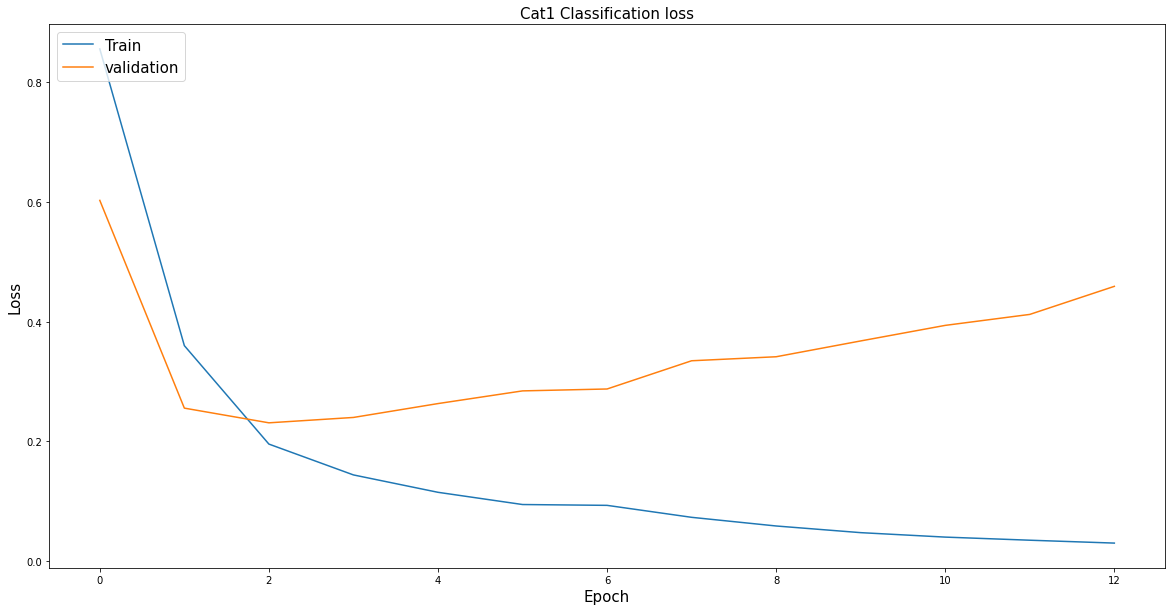

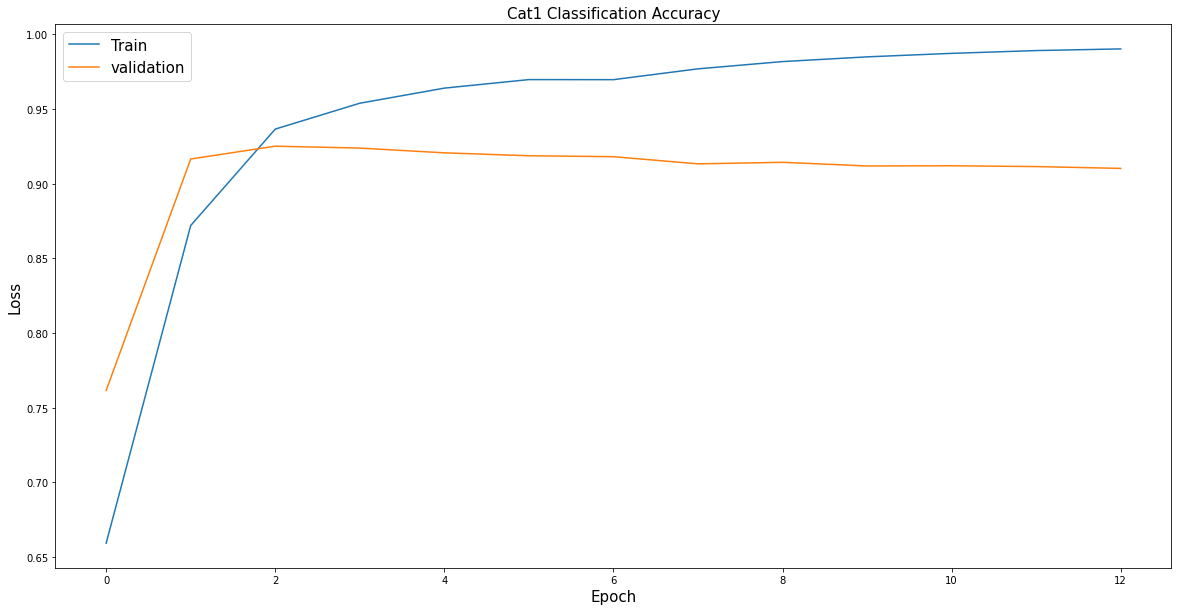

In [ ]:
# Plot training & validation loss values
plt.figure(figsize = (20, 10))
plt.plot(history_seq2seq.history['loss'])
plt.plot(history_seq2seq.history['val_loss'])
plt.title('Cat1 Classification loss', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.xlabel('Epoch', fontsize = 15)
plt.legend(['Train', 'validation'], loc='upper left', fontsize = 15)
plt.show();

# Plot training & validation accuracy values
plt.figure(figsize = (20, 10))
plt.plot(history_seq2seq.history['accuracy'])
plt.plot(history_seq2seq.history['val_accuracy'])
plt.title('Cat1 Classification Accuracy', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.xlabel('Epoch', fontsize = 15)
plt.legend(['Train', 'validation'], loc='upper left', fontsize = 15)
plt.show();

In [ ]:
attention_score_test = model_cat6.evaluate([encoder_input_test, decoder_input_test1], decoder_target_test1)

231/231 [==============================] - 32s 137ms/step - loss: 0.4588 - accuracy: 0.9103


In [ ]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index1 = tar_tokenizer1.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word1 = tar_tokenizer1.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [ ]:
# 인코더 설계
encoder_model = Model(inputs = encoder_inputs, outputs = [encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape = (hidden_size,))
decoder_state_input_c = Input(shape = (hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해선 초기 상태(intial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현

# 훈련 과정에서와 달리, LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 간직하고 있음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state = [decoder_state_input_h,
                                                                               decoder_state_input_c])

# 어텐션 함수
decoder_hidden_state_input = Input(shape= (75, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat)

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2]
)

In [ ]:
def decode_sequence1(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index1['sos']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word1[sampled_token_index]

        if(sampled_token!='eos'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eos'  or len(decoded_sentence.split()) >= 5):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i != 0):
            temp += src_index_to_word[i]+' '
    return temp

def seq2cat1(input_seq):
    temp=''
    for i in input_seq:
        if ((i != 0 and i != tar_word_to_index1['sos']) and i != tar_word_to_index1['eos']):
            temp += tar_index_to_word1[i] + ' '

    return temp

In [ ]:
for i in range(1, 100):
    print("원문 : ",seq2text(encoder_input_test[i]))
    print("실제 카테고리 :",seq2cat1(decoder_input_test1[i]))
    print("예측 카테고리 :",decode_sequence1(encoder_input_test[i].reshape(1, 75)))
    print("\n")

원문 :  worst diaper used different brand pampers quantity mean good quality ready yet giving pampers try make final decision move another brand diapers hoping still continue business since using brand years children 
실제 카테고리 : babyproducts 
예측 카테고리 :  babyproducts


원문 :  omg glad found soap really says feel difference skin using never going back store brand beauty bars ordered rose scented one smell perfect strong light 
실제 카테고리 : beauty 
예측 카테고리 :  beauty


원문 :  worked way clean stained areas seemed cut condition must corrected inside got product stressed cost little angel eyes clear staining drainage itchy eyes worth every penny however still put expense first bottle hoped results would remain staining began within weeks seemed take forever get refill order clear buy biggest bottles best savings use like little salt food use much less recommended dosage every day little angel though finicky food thank much let know sale com 
실제 카테고리 : petsupplies 
예측 카테고리 :  petsupplies


원문 :  love

In [ ]:
x = {}
for i in range(500):
    x[i] = [seq2cat1(decoder_input_test1[i]), decode_sequence1(encoder_input_test[i].reshape(1, 75))]
    # print("원문 : ",seq2text(encoder_input_test[i]))
    # print("실제 카테고리 :",seq2cat2(decoder_input_test2[i]))
    # print("예측 카테고리 :",decode_sequence2(encoder_input_test[i].reshape(1, 75)))
    # print("\n")


count = 0
for i in range(500):
    if x[i][0].replace(' ','') != x[i][1].replace(' ',''):
        count += 1
    else :
        continue

print('0번에서 500번까지에서 카테고리 불일치 수:',count)

0번에서 500번까지에서 카테고리 불일치 수: 72


501개의 데이터 중, 카테고리가 일치하지 않는 수를 테스트 해본 결과 72개 정도로 나온다.

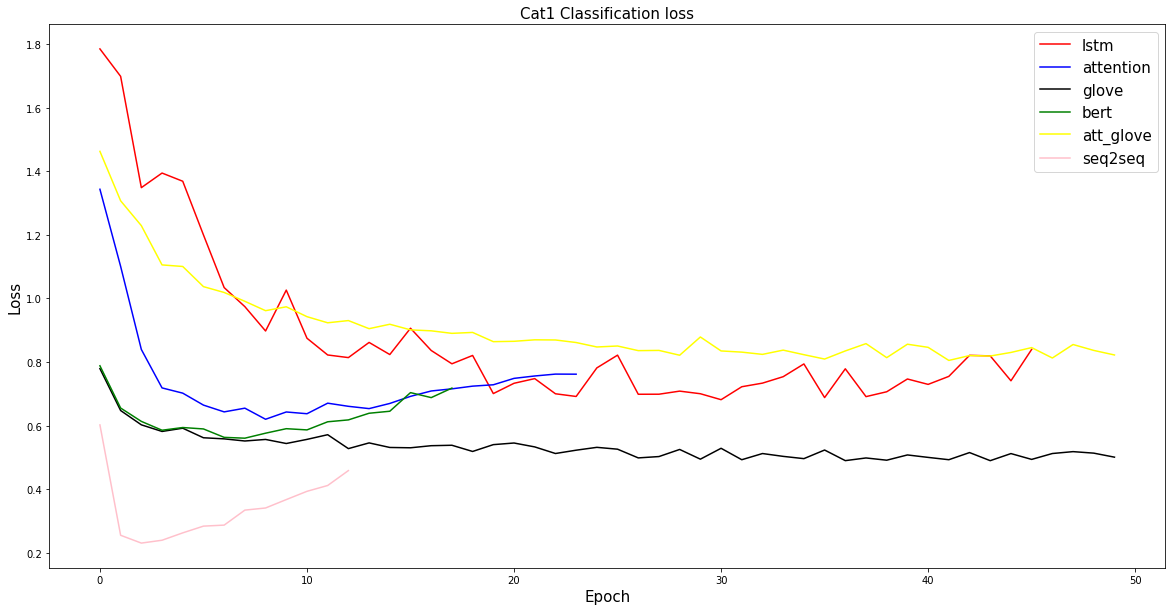

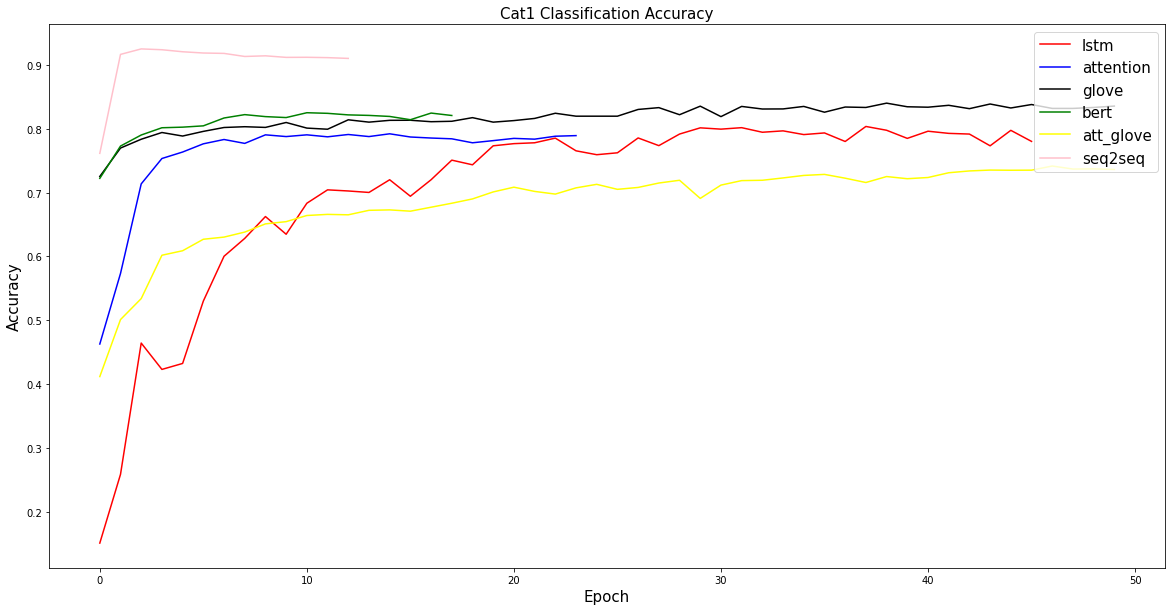

In [ ]:
# Plot training & validation loss values
plt.figure(figsize = (20, 10))
plt.plot(history.history['val_loss'], color = 'red', label = 'lstm')
plt.plot(history_attention.history['val_loss'], color = 'blue', label = 'attention')
plt.plot(history_glove.history['val_loss'], color = 'black', label = 'glove')
plt.plot(history_bert.history['val_loss'], color = 'green', label = 'bert')
plt.plot(history_att_glove.history['val_loss'], color = 'yellow', label = 'att_glove')
plt.plot(history_seq2seq.history['val_loss'], color = 'pink', label = 'seq2seq')
plt.title('Cat1 Classification loss', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.xlabel('Epoch', fontsize = 15)
plt.legend(['lstm', 'attention', 'glove', 'bert', 'att_glove', 'seq2seq'], loc='upper right', fontsize = 15)
plt.show();

# Plot training & validation accuracy values
plt.figure(figsize = (20, 10))
plt.plot(history.history['val_accuracy'], color = 'red', label = 'lstm')
plt.plot(history_attention.history['val_accuracy'], color = 'blue', label = 'attention')
plt.plot(history_glove.history['val_accuracy'], color = 'black', label = 'glove')
plt.plot(history_bert.history['val_accuracy'], color = 'green', label = 'bert')
plt.plot(history_att_glove.history['val_accuracy'], color = 'yellow', label = 'att_glove')
plt.plot(history_seq2seq.history['val_accuracy'], color = 'pink', label = 'seq2seq')
plt.title('Cat1 Classification Accuracy', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.xlabel('Epoch', fontsize = 15)
plt.legend(['lstm', 'attention', 'glove', 'bert', 'att_glove', 'seq2seq'], loc='upper right', fontsize = 15)
plt.show();

전체 모델을 시각화 한 결과, Sequence to Sequence 모델이 가장 빠르게 epochs이 끝난 것을 확인할 수 있다. 그 말은 즉, 가장 빠르게 손실함수가 최소화되는 지점에 도달했다라는 것으로 해석할 수 있다.

In [ ]:
lstm_score = [0.8953, 0.7467]
lstm_att_score = [0.8059, 0.7592]
glove_score = [0.5580, 0.8105]
bert_score= [0.6310, 0.7831]
lstm_att_glove = [0.8605, 0.7103]
seq2seq_score = [0.4588, 0.9103]

In [ ]:
score = pd.DataFrame([lstm_score, lstm_att_score, glove_score, bert_score, lstm_att_glove, seq2seq_score], columns = ['loss', 'accuracy'], index = ['LSTM', 'LSTM with Attention', 'LSTM(Glove)', 'BERT', 'LSTM(Glove) with attention', 'Seq2Seq(Lstm with attention)'])
score

,loss,accuracy
LSTM,0.8953,0.7467
LSTM with Attention,0.8059,0.7592
LSTM(Glove),0.5580,0.8105
BERT,0.6310,0.7831
LSTM(Glove) with attention,0.8605,0.7103
Seq2Seq(Lstm with attention),0.4588,0.9103


성능이 가장 좋았던 Sequence to Sequence 모델을 통해 Cat2(64개 클래스)를 예측해본다.

In [ ]:
embedding_dim = 256
hidden_size = 512

# 인코더
encoder_inputs = Input(shape=(75,))

# 인코더의 임베딩 층
enc_emb = Embedding(10000, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# 디코더
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab2, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])


# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab2, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model_cat64 = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model_cat64.summary()


attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab2, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model_cat64 = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model_cat64.summary()

model_cat64.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 75)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 75, 256)      2560000     input_4[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 75, 512), (N 1574912     embedding_2[0][0]                
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [ ]:
decoder_input_test2

array([[ 1, 16],
       [ 1,  5],
       [ 1, 10],
       ...,
       [ 1,  3],
       [ 1, 18],
       [ 1, 18]], dtype=int32)

In [ ]:
model_name = "attention_64"

checkpoint_path = os.path.join(model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

        # Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
            
cp_callback = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 10)
history_seq2seq_64 = model_cat64.fit(x = [encoder_input_train, decoder_input_train2], y = decoder_target_train2, \
          validation_data = ([encoder_input_test, decoder_input_test2], decoder_target_test2),
          batch_size = 256, callbacks=[es, cp_callback], epochs = 50)

## TPU 끊겨버림..

attention_64 -- Folder already exists 

Epoch 1/50
 37/116 [========>.....................] - ETA: 32:17 - loss: 2.3178 - accuracy: 0.4980

In [ ]:
pip freeze > requirements.txt